Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import LayerNorm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from numpy.fft import fft, fftfreq
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings("ignore")

Dataset Loading

In [2]:
df = pd.read_excel("Solar_Forecast_Dataset_FYP.xlsx")

Exploratory Data Analysis 

In [3]:
display(df.head())

Datetime       Date Time_hrs  Mean_Module_Temperature_deg_oC  \
0 2013-01-01 01:00:00 2013-01-01    01:00                       22.100000   
1 2013-01-01 02:00:00 2013-01-01    02:00                       22.150000   
2 2013-01-01 03:00:00 2013-01-01    03:00                       22.450000   
3 2013-01-01 04:00:00 2013-01-01    04:00                       22.841667   
4 2013-01-01 05:00:00 2013-01-01    05:00                       21.983333   

   Mean_Open_Air_Temperature_deg_oC  Global_horizontal_irradiance_GHI_W/m2  \
0                             24.00                                    0.0   
1                             24.20                                    0.0   
2                             24.50                                    0.0   
3                             24.50                                    0.0   
4                             23.65                                    0.0   

   Tilt_solar_incident_radiation_w/m2  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   

   Diffuse_Horizontal_incident_radiation_DHI  Power_Generation_kW  \
0                                        0.0                  0.5   
1                                        0.0                  0.0   
2                                        0.0                  0.5   
3                                        0.0                  0.5   
4                                        0.0                  0.0   

   Power_Generation_Output_kWh  Co2_Reduction_kg  Precipitation_mm  \
0                          0.0               0.0               0.0   
1                          0.0               0.0               0.0   
2                          0.0               0.0               0.0   
3                          0.0               0.0               0.5   
4                          0.0               0.0               0.0   

   Wind_Speed_m/s  
0             3.9  
1             3.0  
2             4.8  
3             6.1  
4             4.7

In [4]:
print("Dataset shape:", df.shape)

Dataset shape: (8760, 13)


In [5]:
df.info()          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Datetime                                   8760 non-null   datetime64[ns]
 1   Date                                       8760 non-null   datetime64[ns]
 2   Time_hrs                                   8760 non-null   object        
 3   Mean_Module_Temperature_deg_oC             8758 non-null   float64       
 4   Mean_Open_Air_Temperature_deg_oC           8758 non-null   float64       
 5   Global_horizontal_irradiance_GHI_W/m2      8758 non-null   float64       
 6   Tilt_solar_incident_radiation_w/m2         8758 non-null   float64       
 7   Diffuse_Horizontal_incident_radiation_DHI  8758 non-null   float64       
 8   Power_Generation_kW                        8758 non-null   float64       
 9   Power_Generation_Ou

In [6]:
df.describe().T    # numeric summary

count        mean         std  \
Mean_Module_Temperature_deg_oC             8758.0   30.920900   11.139639   
Mean_Open_Air_Temperature_deg_oC           8758.0   27.057510    2.969260   
Global_horizontal_irradiance_GHI_W/m2      8758.0  232.446208  321.166274   
Tilt_solar_incident_radiation_w/m2         8758.0  226.440746  305.129451   
Diffuse_Horizontal_incident_radiation_DHI  8758.0  107.724525  145.448984   
Power_Generation_kW                        8758.0  117.633706  155.270355   
Power_Generation_Output_kWh                8758.0  123.789107  170.931151   
Co2_Reduction_kg                           8758.0   22.282039   30.767607   
Precipitation_mm                           8758.0    0.153488    1.361879   
Wind_Speed_m/s                             8751.0    3.599949    2.018806   

                                                 min        25%        50%  \
Mean_Module_Temperature_deg_oC             17.908333  22.583333  24.500000   
Mean_Open_Air_Temperature_deg_oC           20.750000  24.700000  26.150000   
Global_horizontal_irradiance_GHI_W/m2       0.000000   0.000000   2.777778   
Tilt_solar_incident_radiation_w/m2          0.000000   0.000000   5.555556   
Diffuse_Horizontal_incident_radiation_DHI   0.000000   0.000000   2.777778   
Power_Generation_kW                         0.000000   0.000000   2.500000   
Power_Generation_Output_kWh                 0.000000   0.000000   0.000000   
Co2_Reduction_kg                            0.000000   0.000000   0.000000   
Precipitation_mm                            0.000000   0.000000   0.000000   
Wind_Speed_m/s                              0.000000   2.000000   3.300000   

                                                  75%          max  
Mean_Module_Temperature_deg_oC              38.981250    66.900000  
Mean_Open_Air_Temperature_deg_oC            29.400000    35.550000  
Global_horizontal_irradiance_GHI_W/m2      463.888889  1116.666667  
Tilt_solar_incident_radiation_w/m2         463.888889  1038.888889  
Diffuse_Horizontal_incident_radiation_DHI  197.222222   638.888889  
Power_Generation_kW                        253.437500   579.500000  
Power_Generation_Output_kWh                250.000000   600.000000  
Co2_Reduction_kg                            45.000000   108.000000  
Precipitation_mm                             0.000000    42.500000  
Wind_Speed_m/s                               4.900000    12.000000

In [7]:
# Checking for duplicates
print(f"Duplicated rows: {df.duplicated().sum()}") 

Duplicated rows: 0


In [8]:
# Checking data types of each column
print("\nData Types of Columns:")
print(df.dtypes)


Data Types of Columns:
Datetime                                     datetime64[ns]
Date                                         datetime64[ns]
Time_hrs                                             object
Mean_Module_Temperature_deg_oC                      float64
Mean_Open_Air_Temperature_deg_oC                    float64
Global_horizontal_irradiance_GHI_W/m2               float64
Tilt_solar_incident_radiation_w/m2                  float64
Diffuse_Horizontal_incident_radiation_DHI           float64
Power_Generation_kW                                 float64
Power_Generation_Output_kWh                         float64
Co2_Reduction_kg                                    float64
Precipitation_mm                                    float64
Wind_Speed_m/s                                      float64
dtype: object


In [9]:
# Checking for missing values
print(df.isnull().sum())

Datetime                                     0
Date                                         0
Time_hrs                                     0
Mean_Module_Temperature_deg_oC               2
Mean_Open_Air_Temperature_deg_oC             2
Global_horizontal_irradiance_GHI_W/m2        2
Tilt_solar_incident_radiation_w/m2           2
Diffuse_Horizontal_incident_radiation_DHI    2
Power_Generation_kW                          2
Power_Generation_Output_kWh                  2
Co2_Reduction_kg                             2
Precipitation_mm                             2
Wind_Speed_m/s                               9
dtype: int64


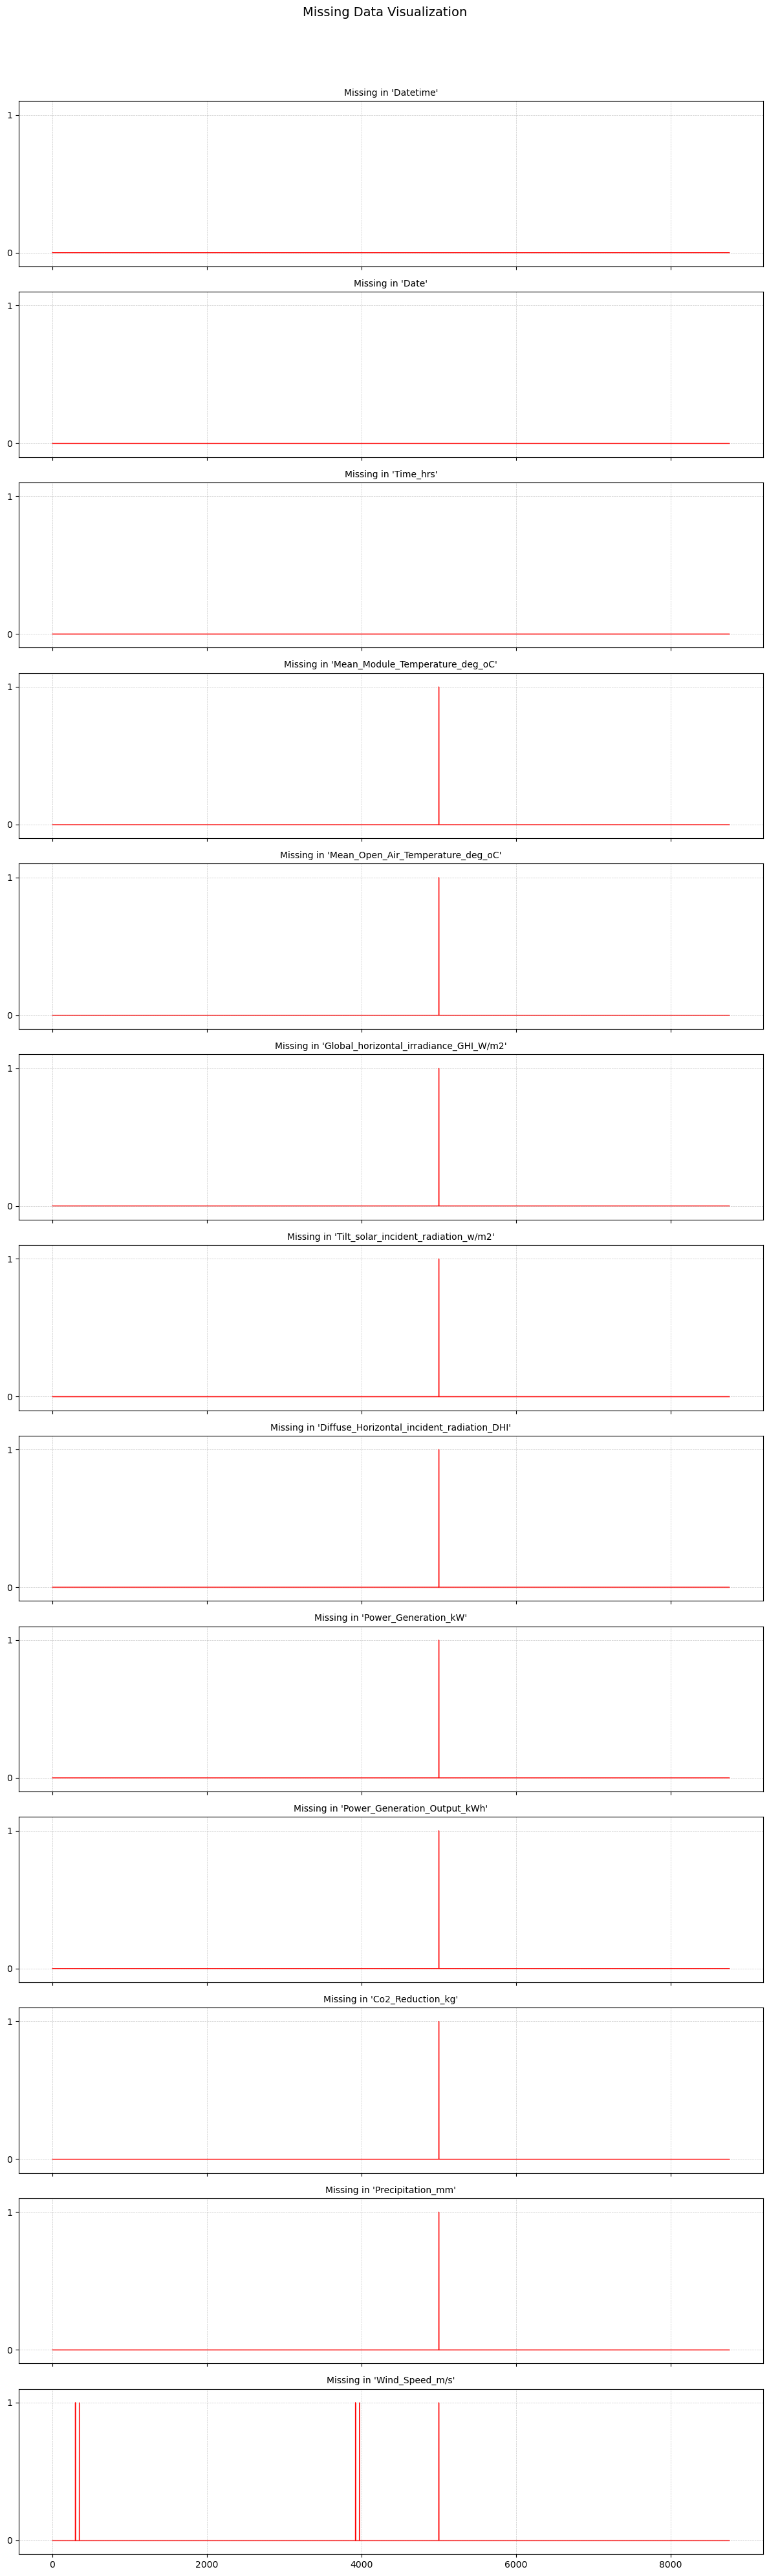

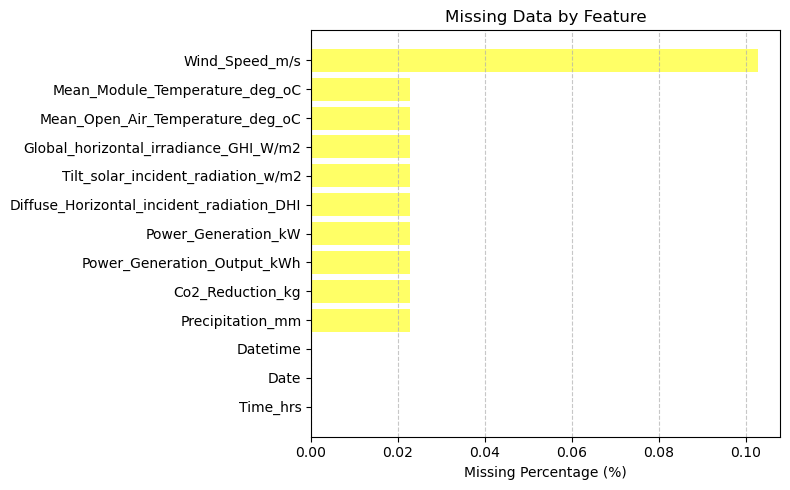

In [10]:
#  Missingness line plots with shading
cols = df.columns
n = len(cols)

fig, axes = plt.subplots(nrows=n, figsize=(12, 3*n), sharex=True)
fig.suptitle("Missing Data Visualization", fontsize=14, y=1.02)

for i, (ax, col) in enumerate(zip(axes, cols)):
    ax.fill_between(df.index, 0, df[col].isna().astype(int),
                    step='pre', color='red', alpha=0.3)
    ax.plot(df.index, df[col].isna(), lw=0.8, color='red')
    ax.set_title(f"Missing in '{col}'", fontsize=10)
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0,1])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

#  Missing percentage bar chart
missing = df.isna().mean().sort_values(ascending=False)*100
missing_df = missing.to_frame('missing_%').reset_index()
missing_df.rename(columns={'index': 'Feature'}, inplace=True)

plt.figure(figsize=(8,5))
plt.barh(missing_df['Feature'], missing_df['missing_%'], color='yellow', alpha=0.6)
plt.gca().invert_yaxis()
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

display(missing_df.style.format({'missing_%': '{:.2f}'}))


In [11]:
# Set the index
df.set_index('Datetime', inplace=True)

# Time interpolation for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='time', limit_direction='both')

In [12]:
print(df.isna().sum())

Date                                         0
Time_hrs                                     0
Mean_Module_Temperature_deg_oC               0
Mean_Open_Air_Temperature_deg_oC             0
Global_horizontal_irradiance_GHI_W/m2        0
Tilt_solar_incident_radiation_w/m2           0
Diffuse_Horizontal_incident_radiation_DHI    0
Power_Generation_kW                          0
Power_Generation_Output_kWh                  0
Co2_Reduction_kg                             0
Precipitation_mm                             0
Wind_Speed_m/s                               0
dtype: int64


Dataset shape: (8760, 12)
First 5 rows of raw data:
                          Date Time_hrs  Mean_Module_Temperature_deg_oC  \
Datetime                                                                  
2013-01-01 01:00:00 2013-01-01    01:00                       22.100000   
2013-01-01 02:00:00 2013-01-01    02:00                       22.150000   
2013-01-01 03:00:00 2013-01-01    03:00                       22.450000   
2013-01-01 04:00:00 2013-01-01    04:00                       22.841667   
2013-01-01 05:00:00 2013-01-01    05:00                       21.983333   

                     Mean_Open_Air_Temperature_deg_oC  \
Datetime                                                
2013-01-01 01:00:00                             24.00   
2013-01-01 02:00:00                             24.20   
2013-01-01 03:00:00                             24.50   
2013-01-01 04:00:00                             24.50   
2013-01-01 05:00:00                             23.65   

                     G

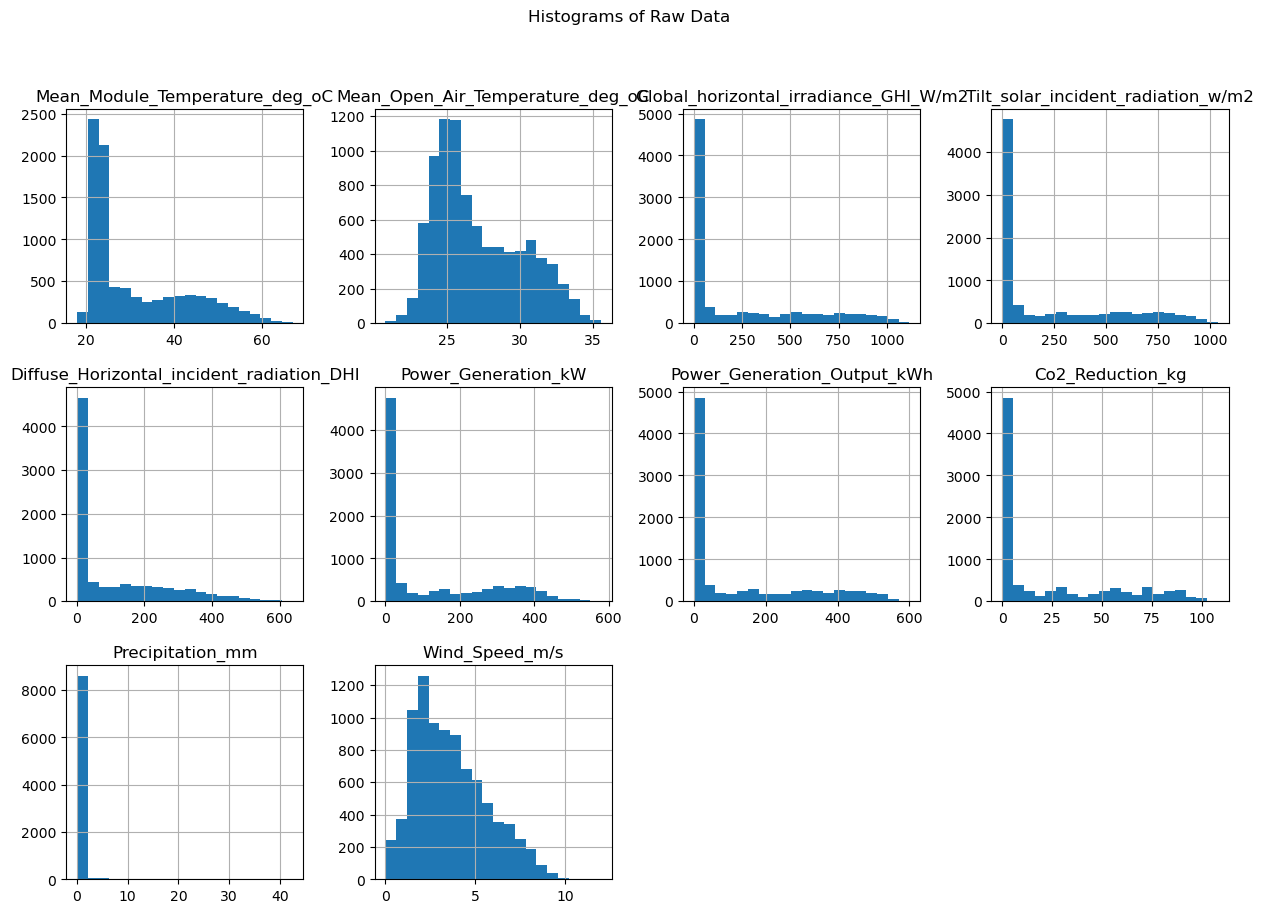

In [13]:
# Load Dataset

print("Dataset shape:", df.shape)
print("First 5 rows of raw data:")
print(df.head())

# Exclude the 'Date' column from the DataFrame for histogram plotting
df_filtered = df.drop(columns=["Date"])

axes = df_filtered.hist(bins=20, figsize=(15, 10), layout=(3, 4))

plt.suptitle("Histograms of Raw Data")
plt.show()

Data Pattern Visualizations for each Feature 

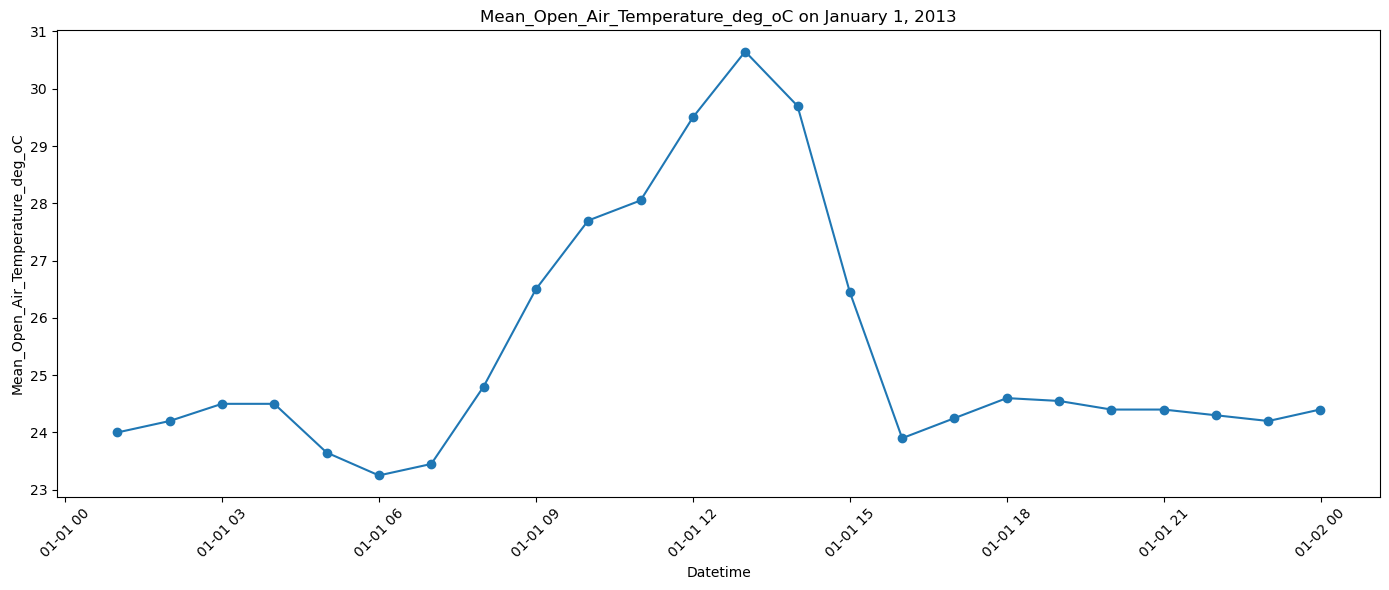

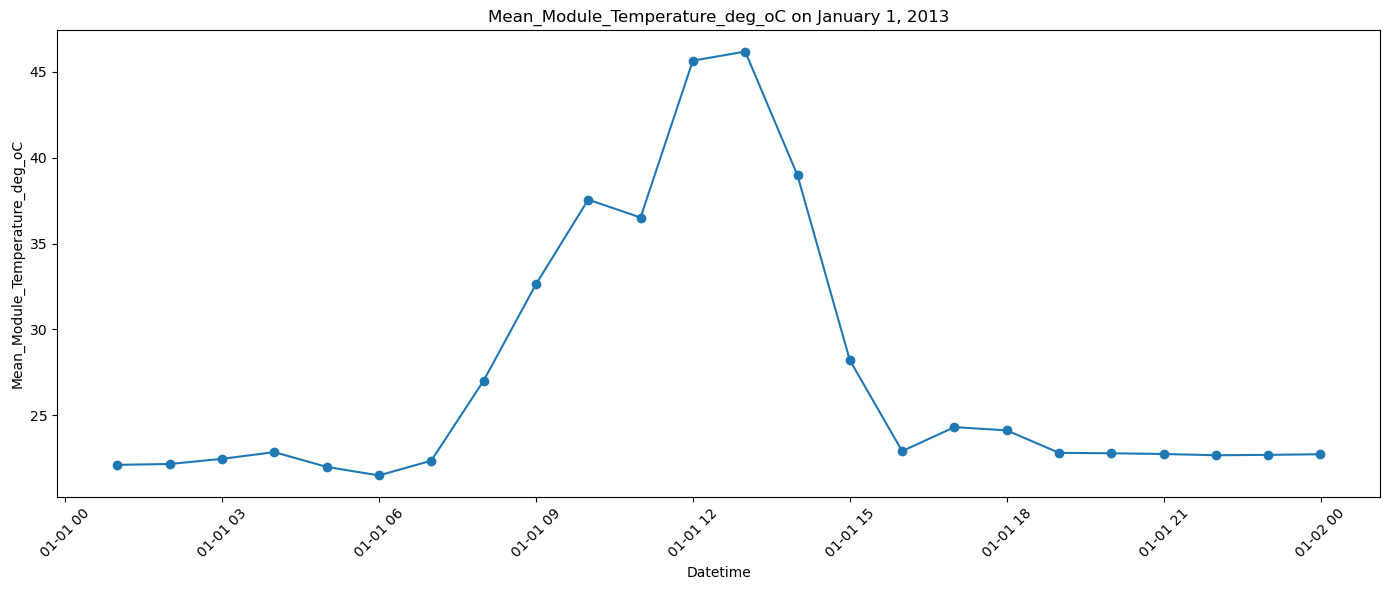

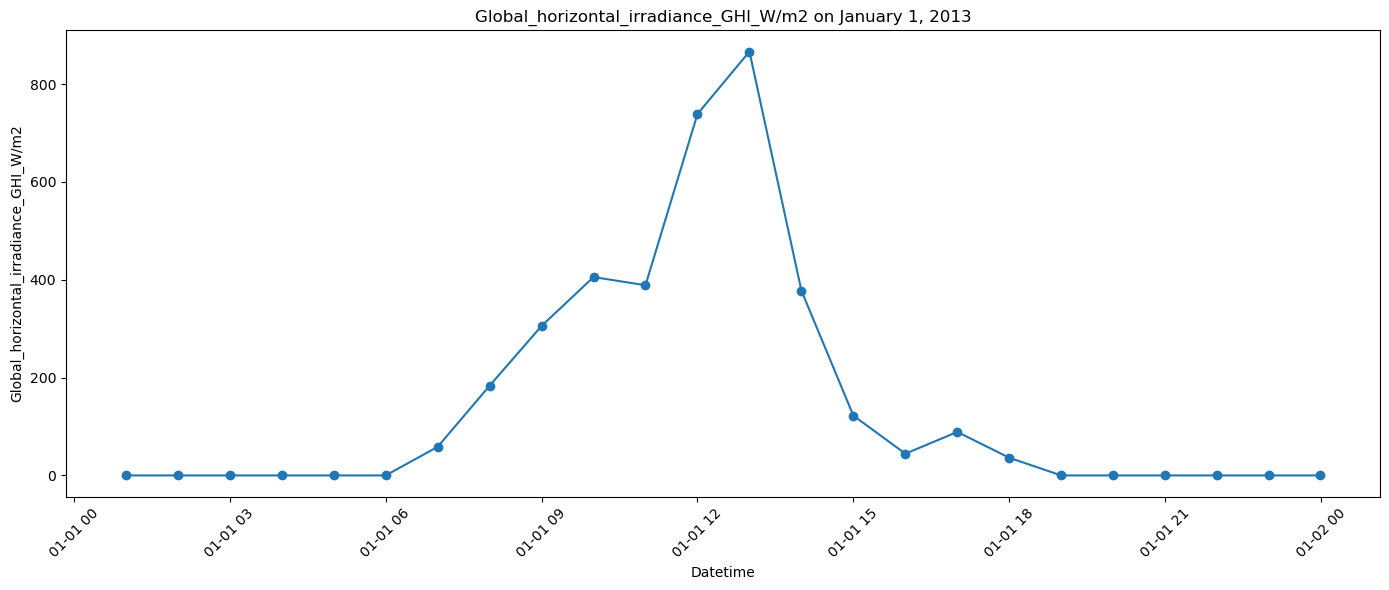

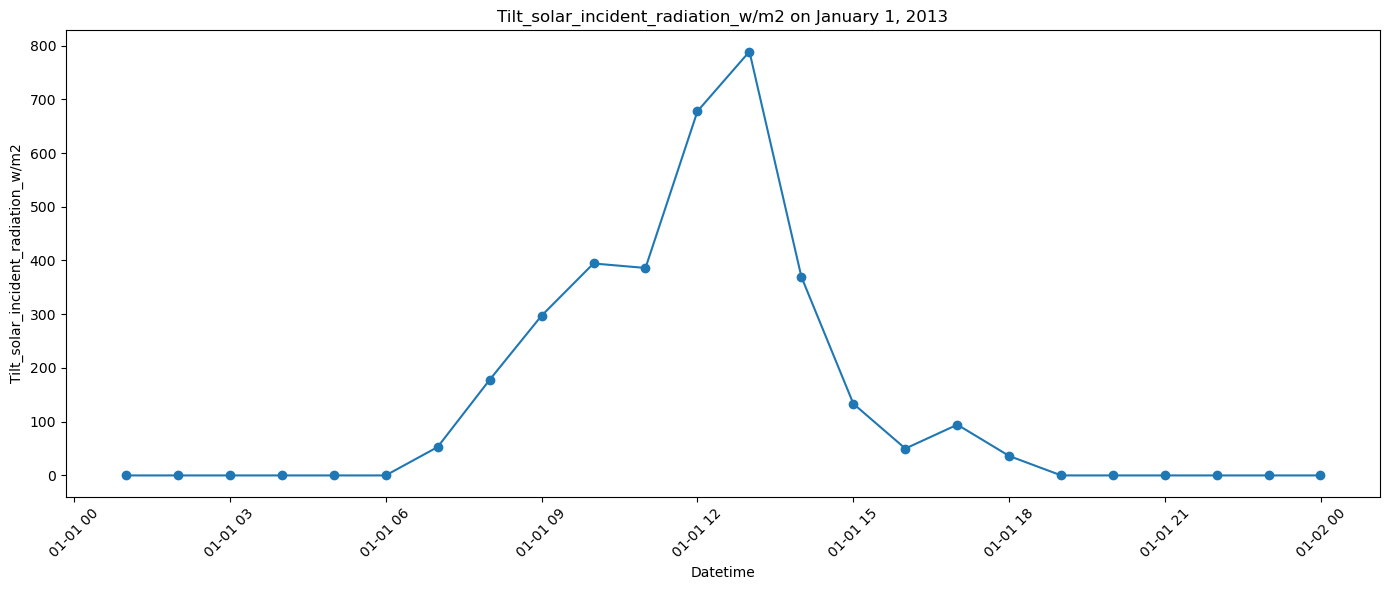

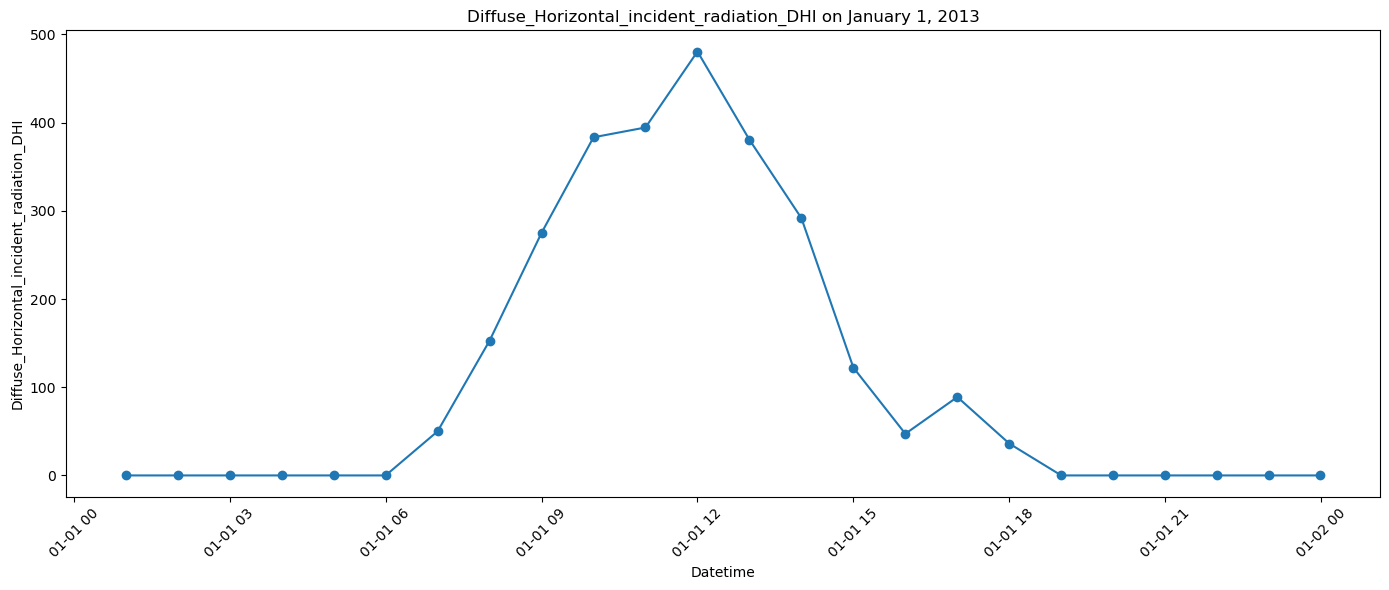

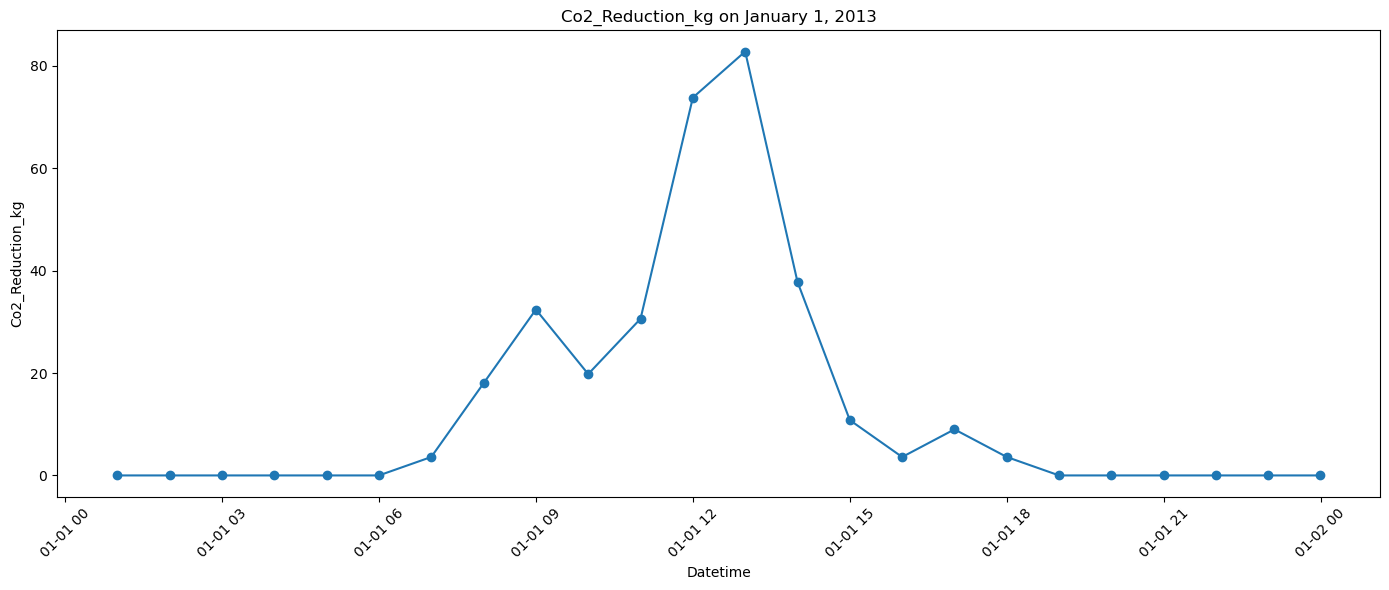

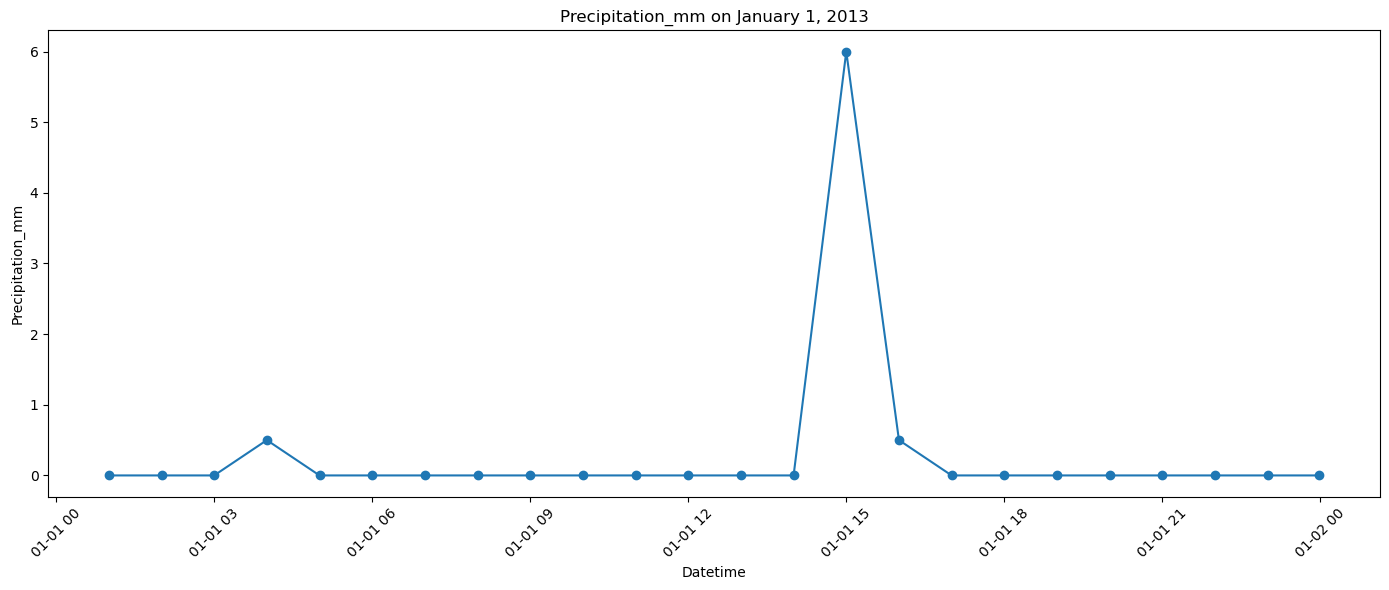

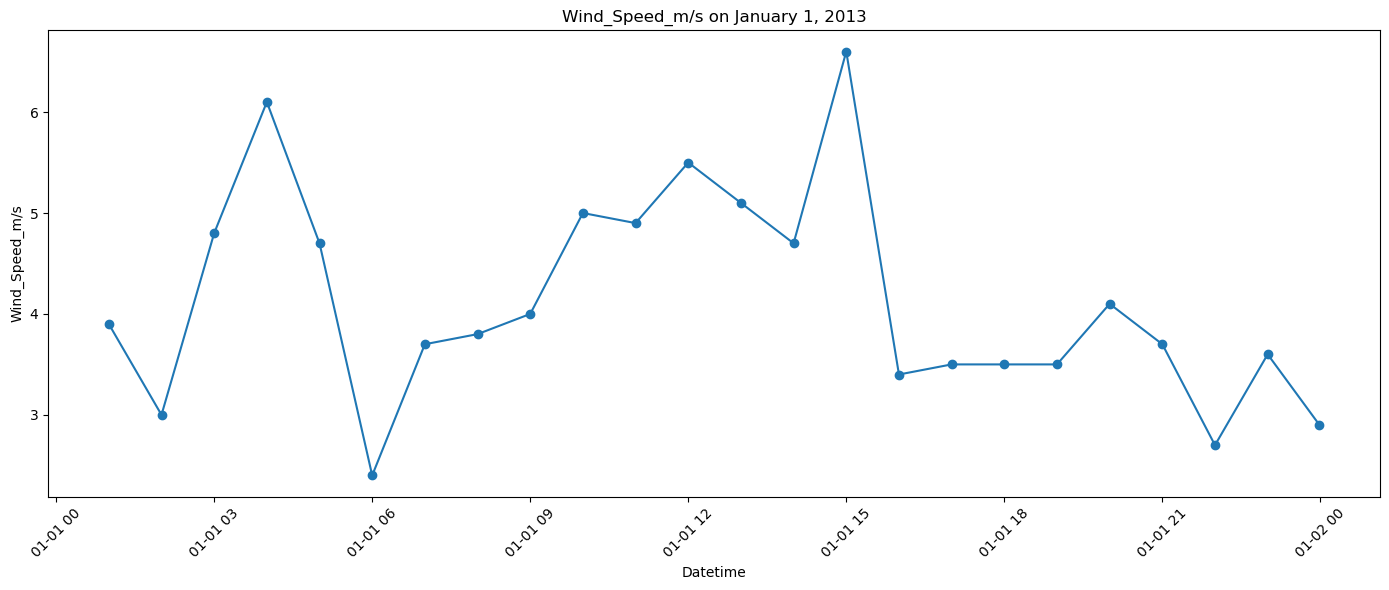

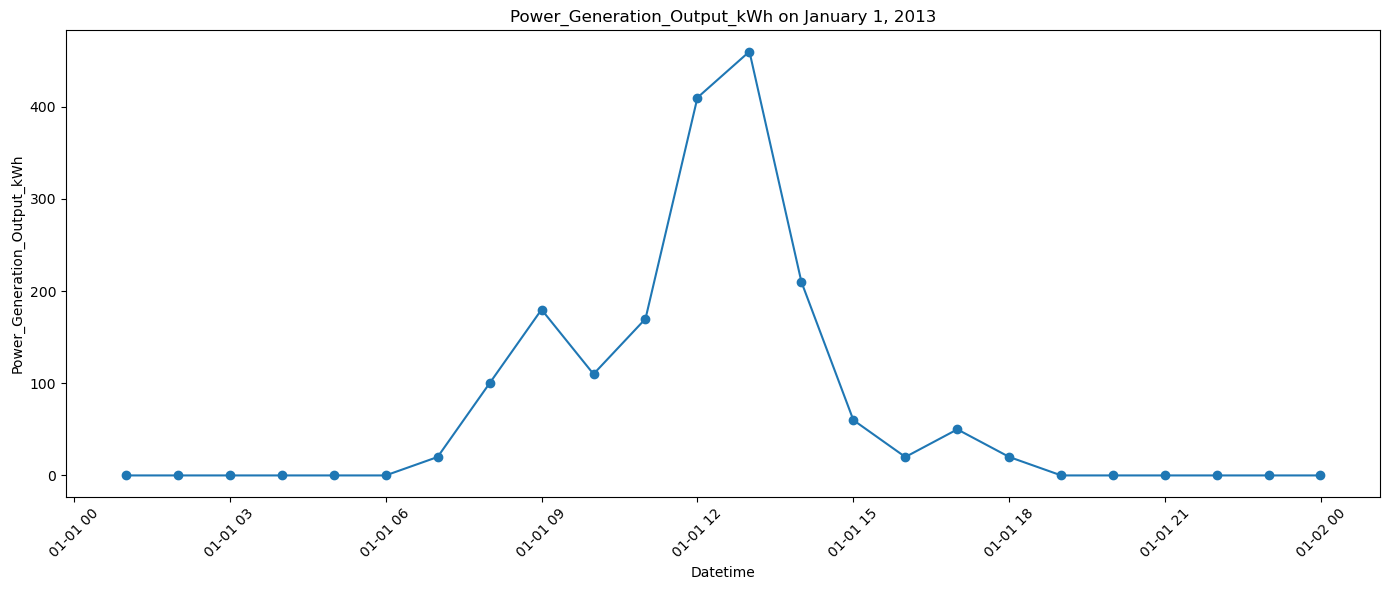

In [14]:
features = [
    "Mean_Open_Air_Temperature_deg_oC",
    "Mean_Module_Temperature_deg_oC",
    "Global_horizontal_irradiance_GHI_W/m2",
    "Tilt_solar_incident_radiation_w/m2",
    "Diffuse_Horizontal_incident_radiation_DHI",
    "Co2_Reduction_kg",
    "Precipitation_mm",
    "Wind_Speed_m/s"
]
target = "Power_Generation_Output_kWh"

plot_features = features + [target]

# Ensure the 'Date' column is in datetime format.
df['Date'] = pd.to_datetime(df['Date'])

# Filter Data
# Filter data for January 2013
january_df = df[(df['Date'].dt.year == 2013) & (df['Date'].dt.month == 1)].copy()

# Filter for January 1st 
jan1_df = january_df[january_df['Date'].dt.day == 1].copy()

# Filter for the first week (days 1 to 7)
jan_week_df = january_df[january_df['Date'].dt.day <= 7].copy()


# Function to combine Date and Time_hrs, with a fix for "24:00"
def combine_date_time(df):
    df['Time_hrs'] = df['Time_hrs'].replace({'24:00': '23:59'})
    return pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Time_hrs'])

# Create a combined datetime for each subset
jan1_df['combined_dt'] = combine_date_time(jan1_df)
jan_week_df['combined_dt'] = combine_date_time(jan_week_df)
january_df['combined_dt'] = combine_date_time(january_df)

# Plotting for January 1st
for col in plot_features:
    plt.figure(figsize=(14, 6))
    plt.plot(jan1_df['combined_dt'], jan1_df[col], marker='o', linestyle='-')
    plt.title(f"{col} on January 1, 2013")
    plt.xlabel("Datetime")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


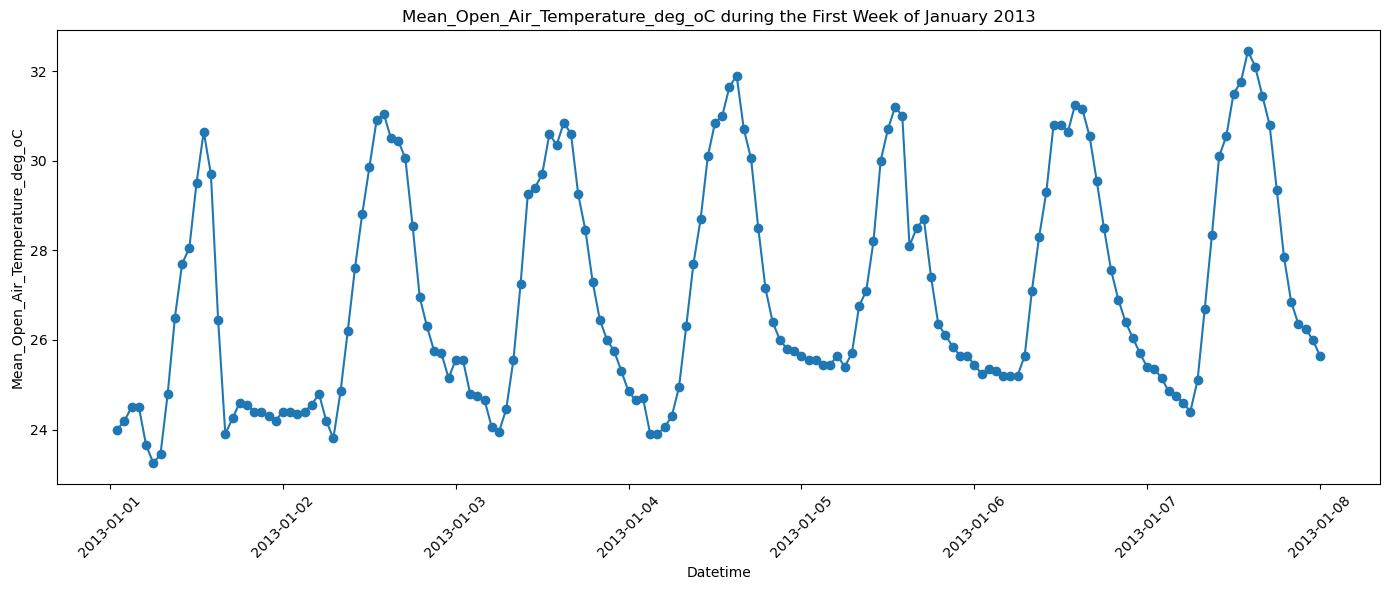

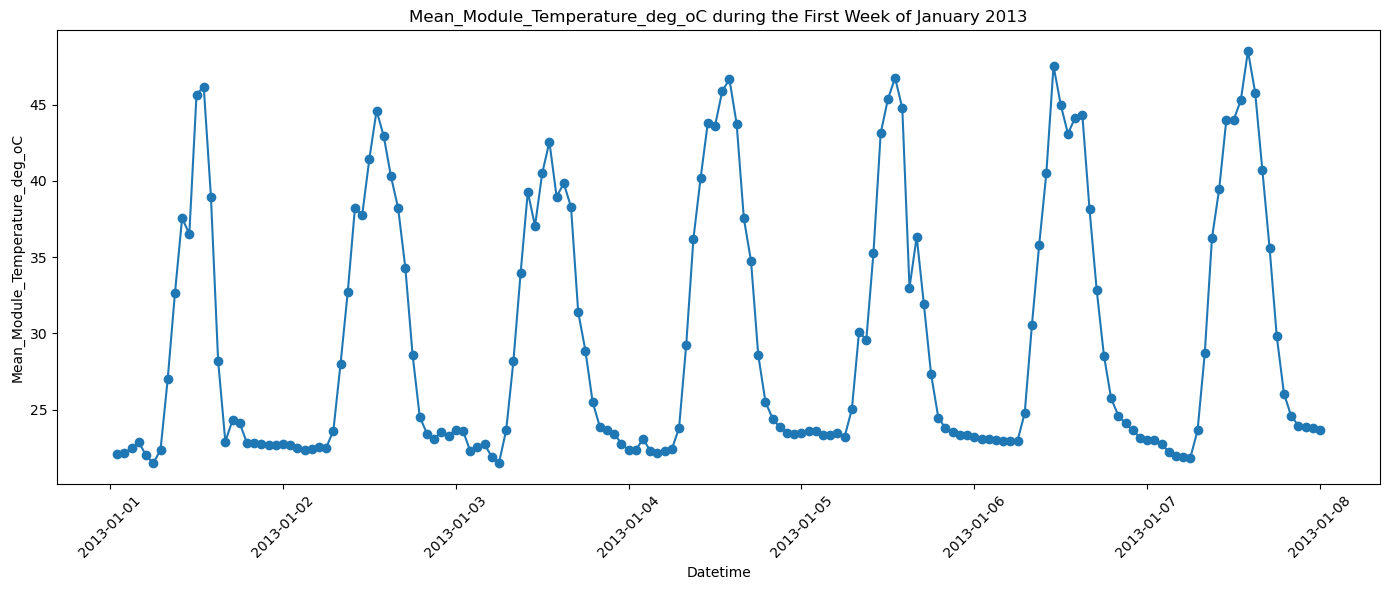

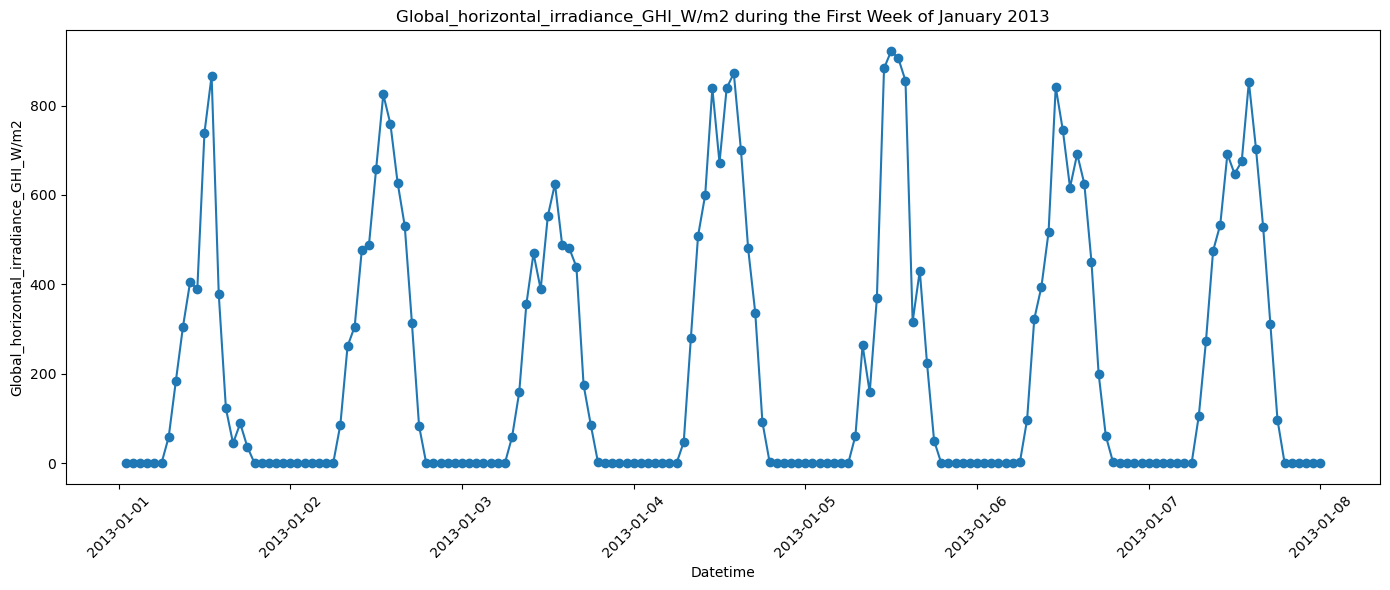

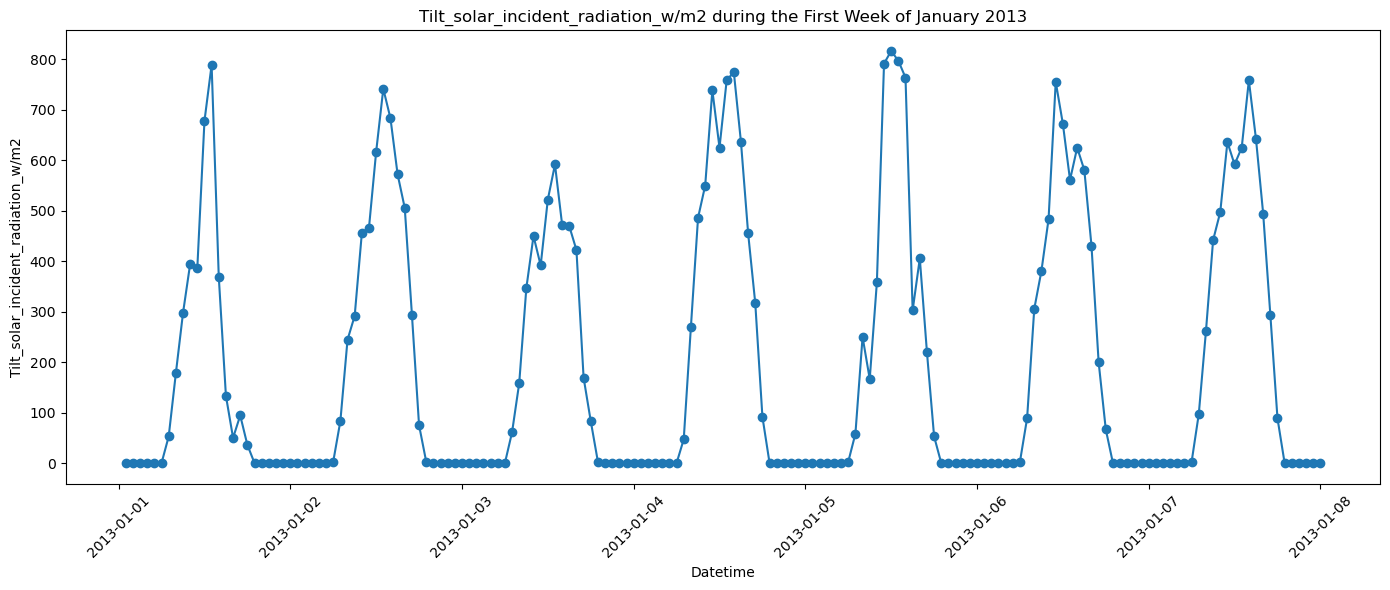

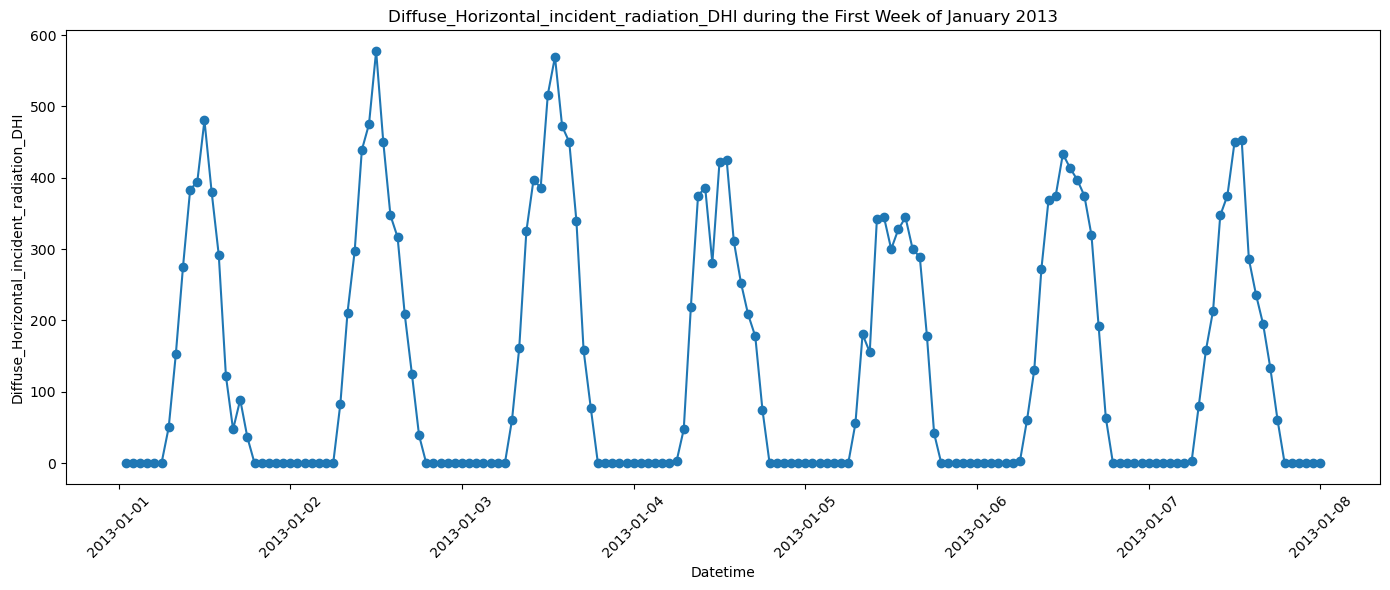

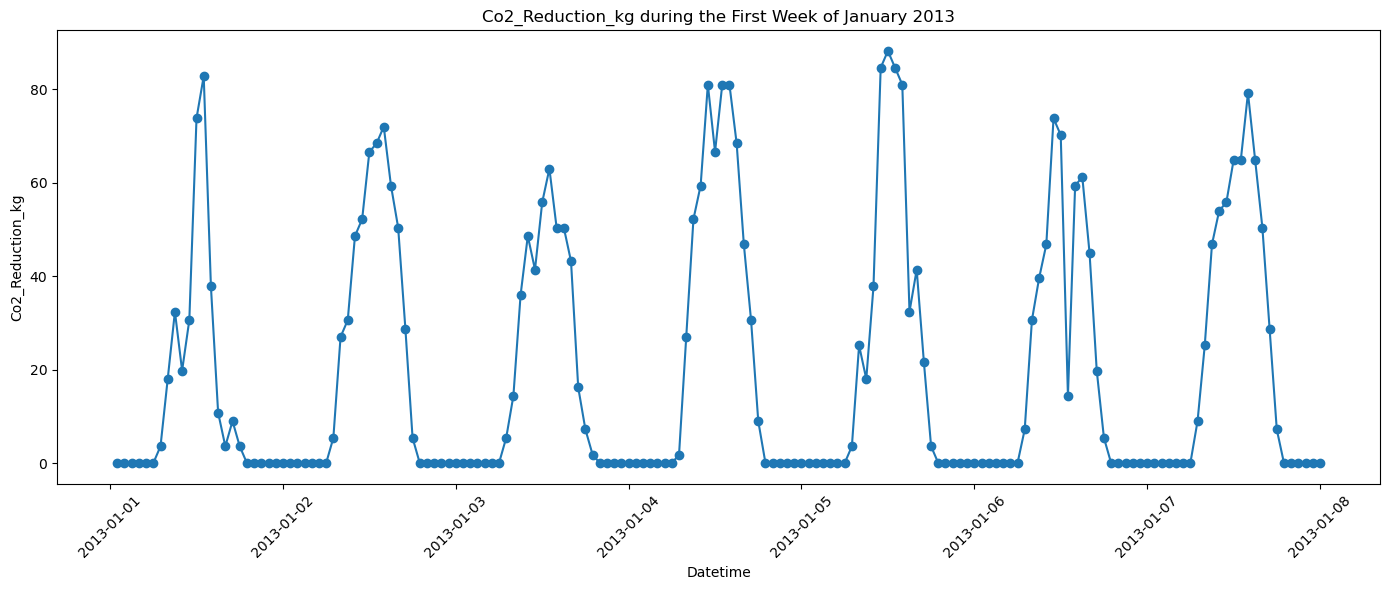

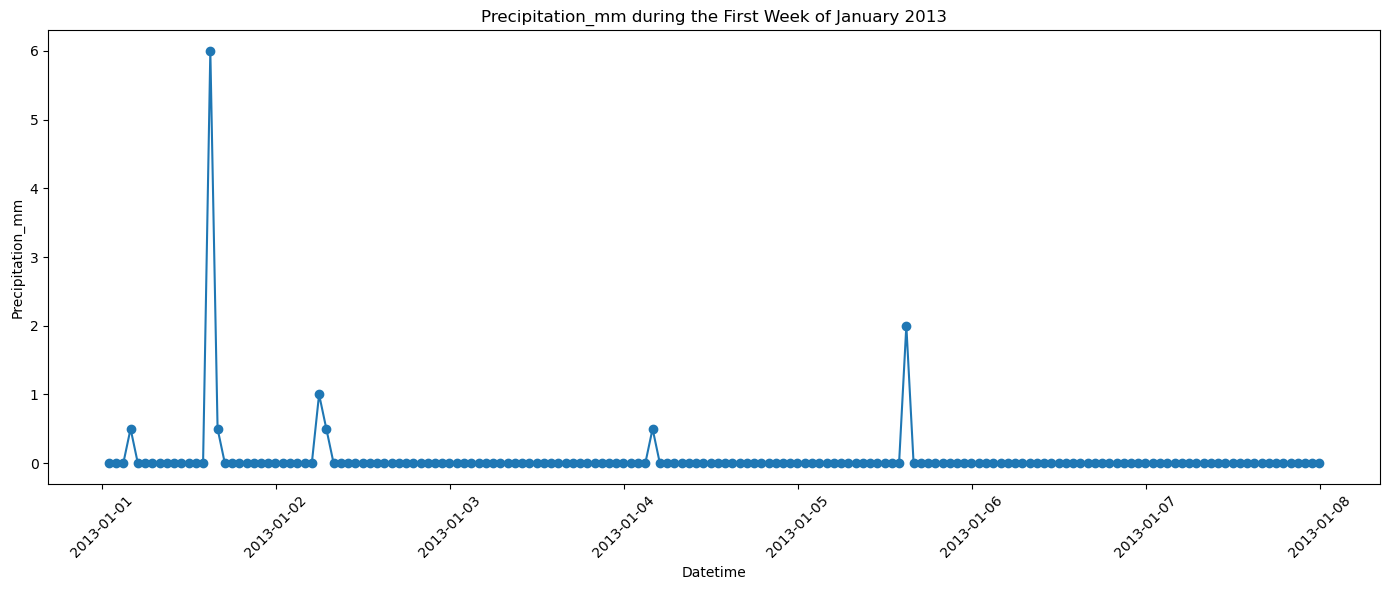

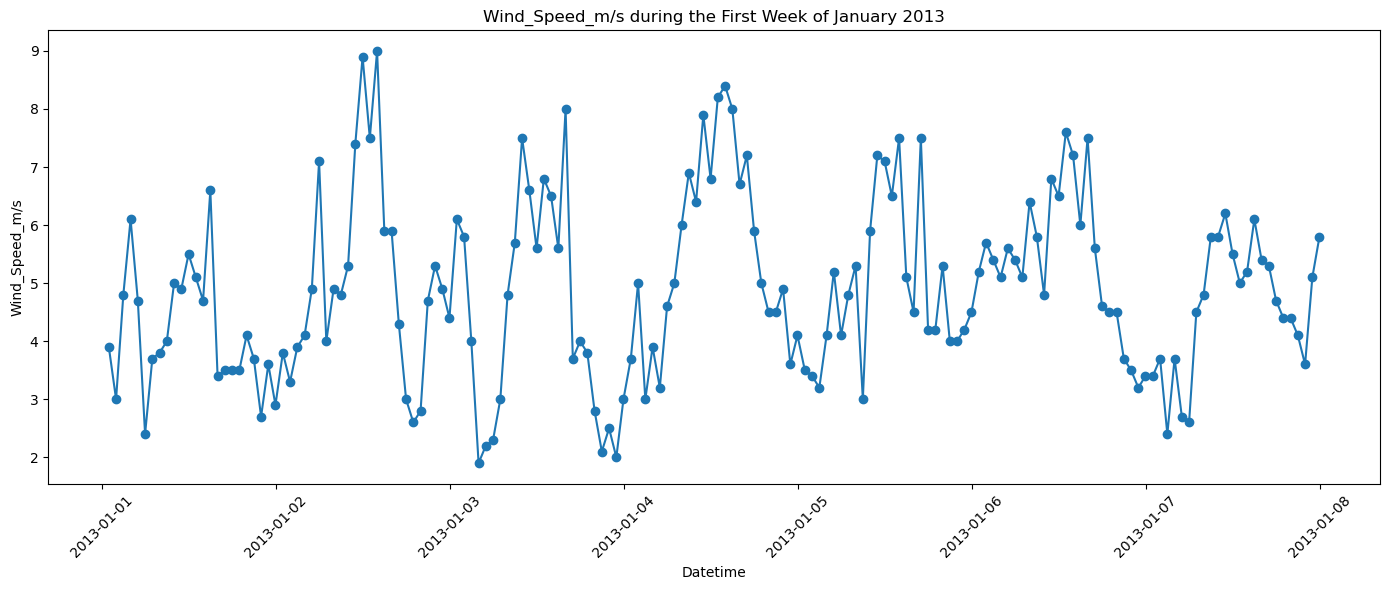

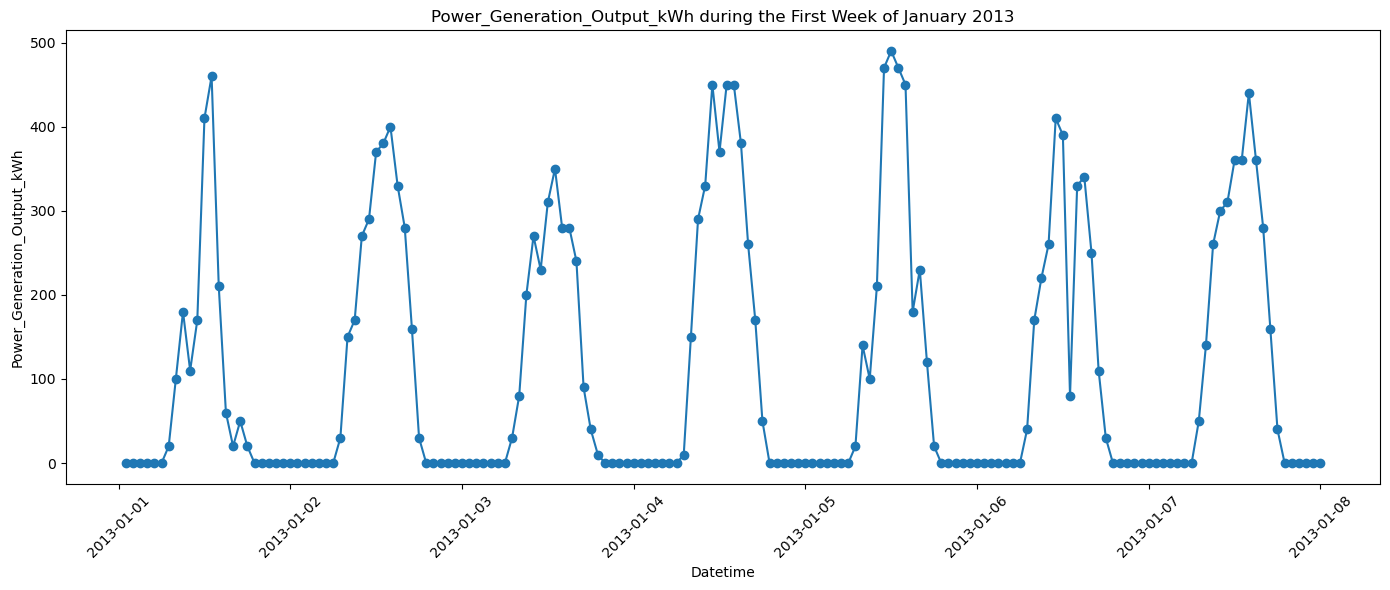

In [15]:
# Plotting for the First Week of January 2013
for col in plot_features:
    plt.figure(figsize=(14, 6))
    plt.plot(jan_week_df['combined_dt'], jan_week_df[col], marker='o', linestyle='-')
    plt.title(f"{col} during the First Week of January 2013")
    plt.xlabel("Datetime")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


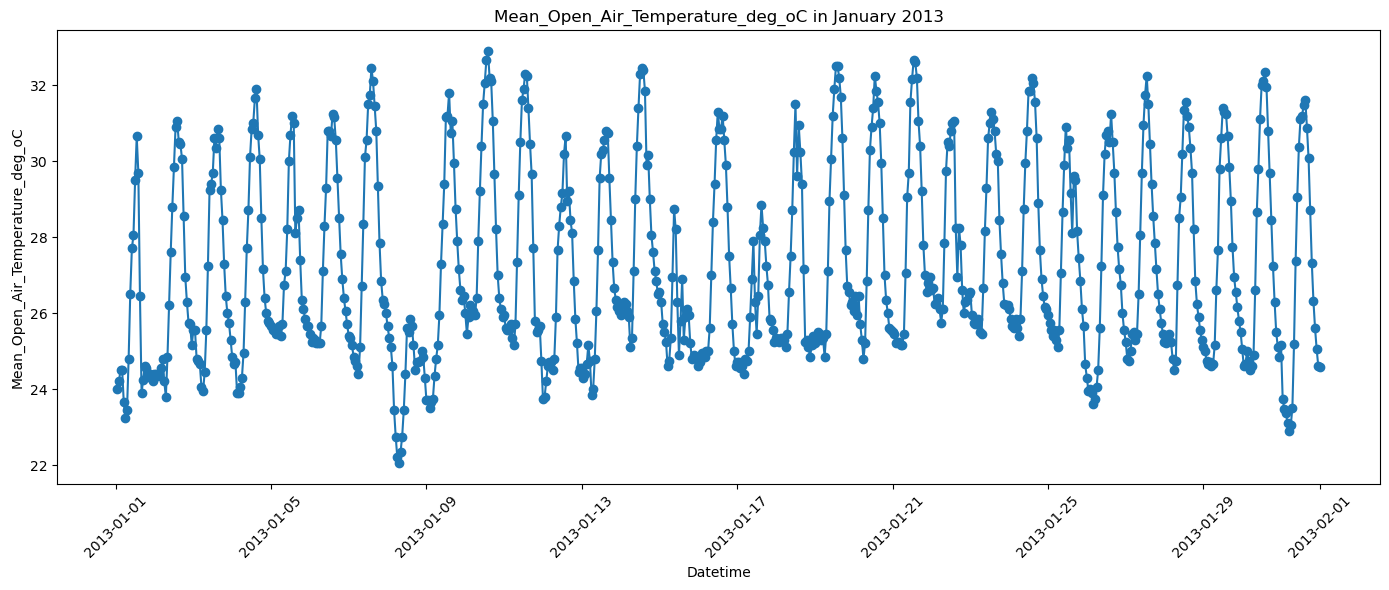

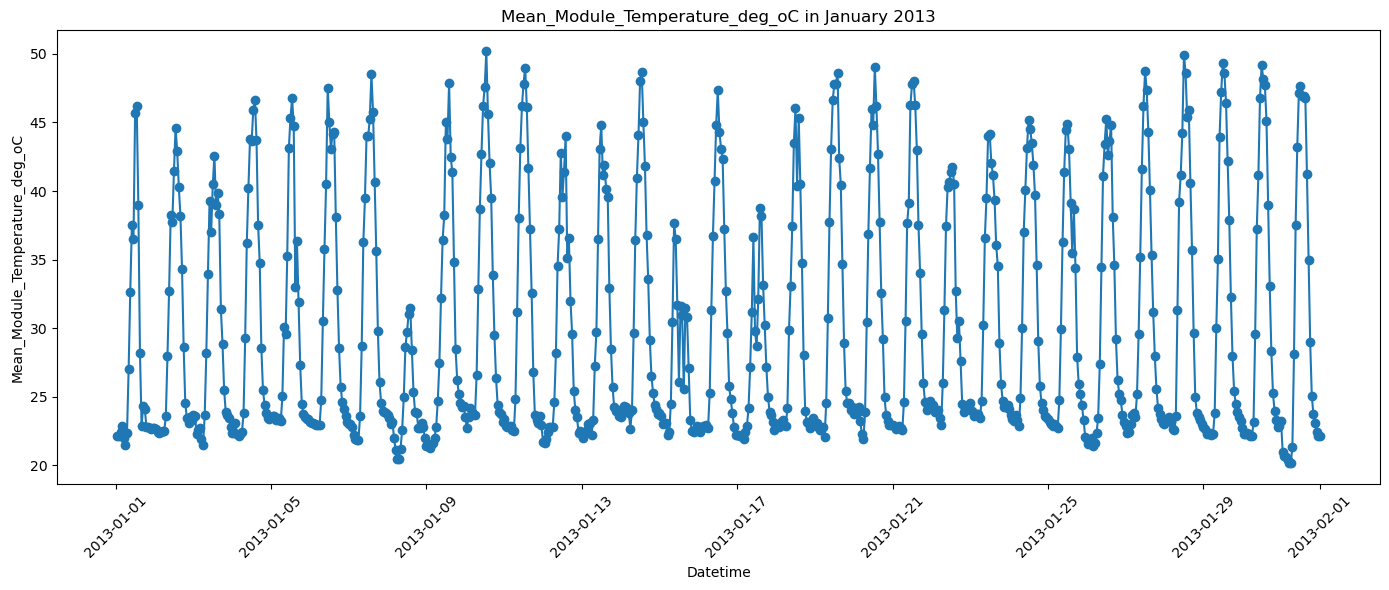

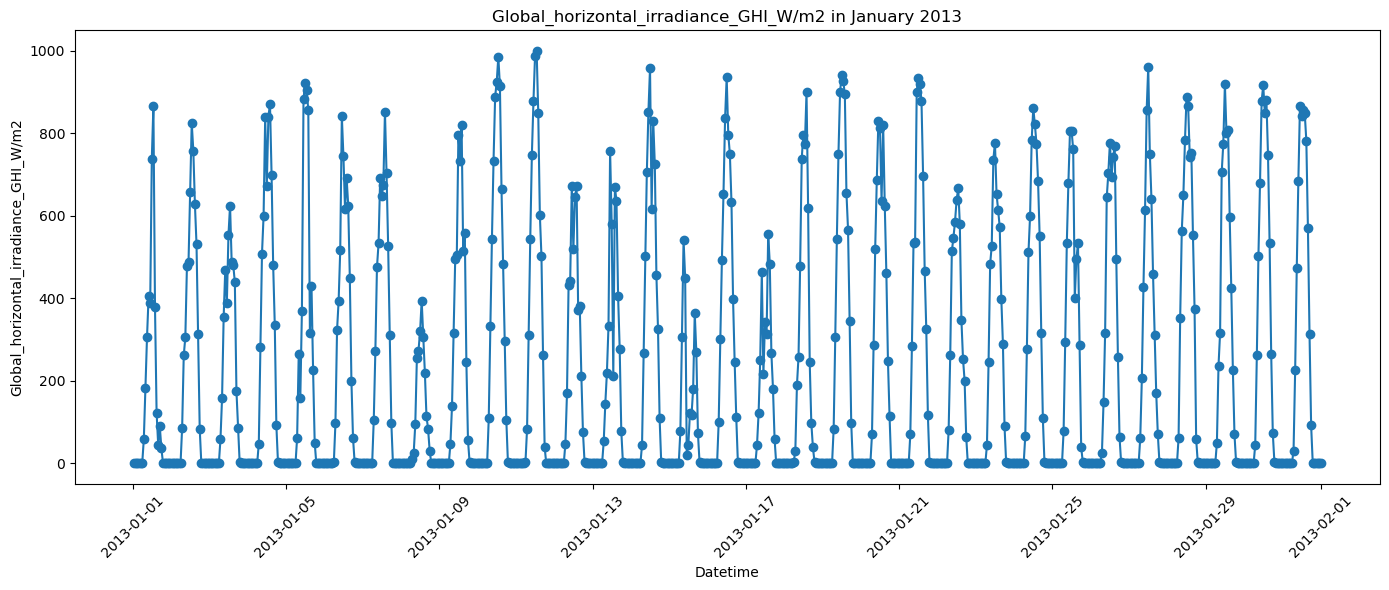

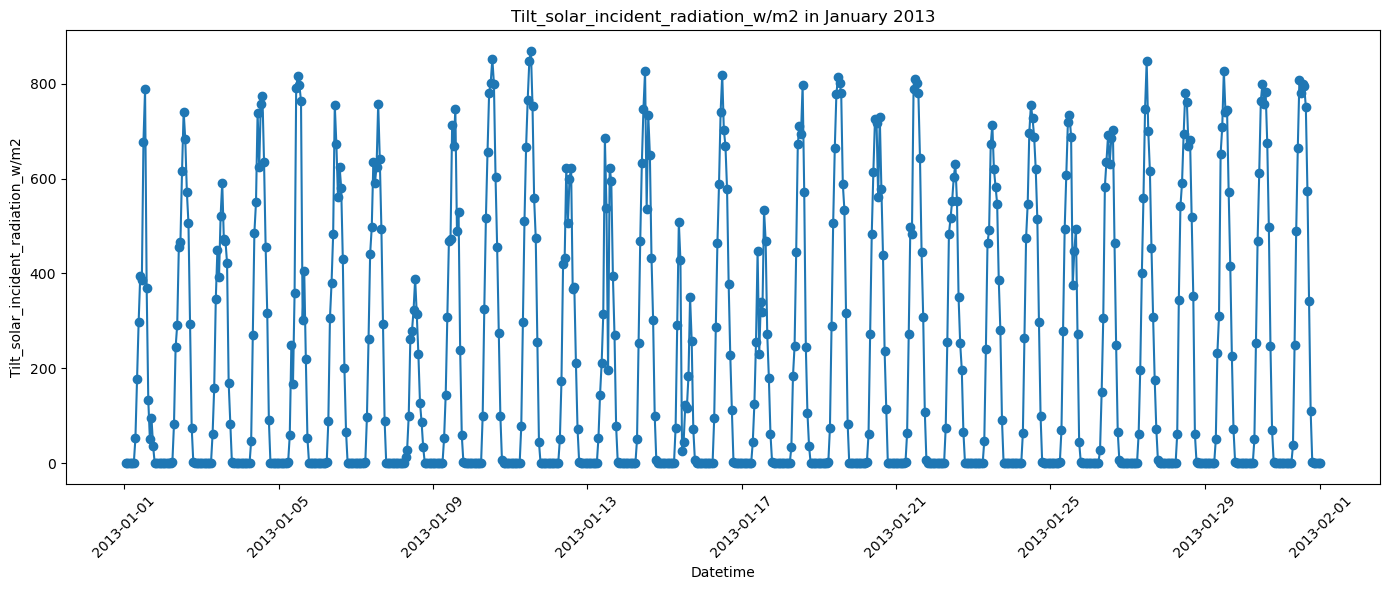

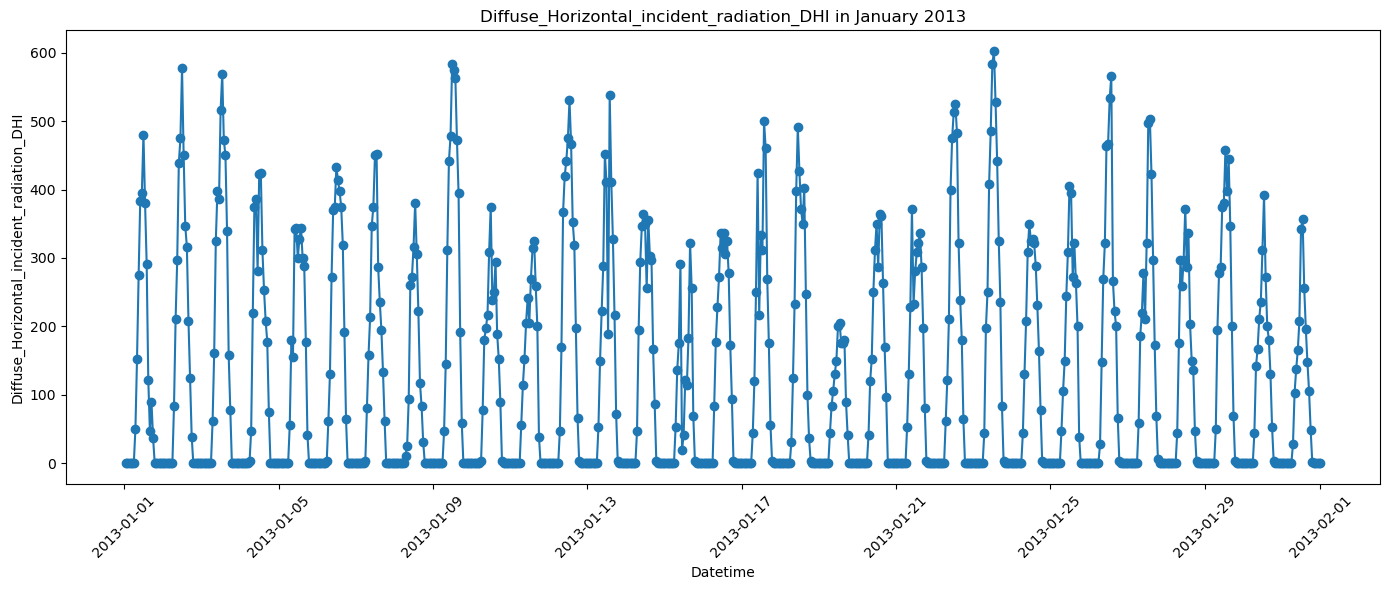

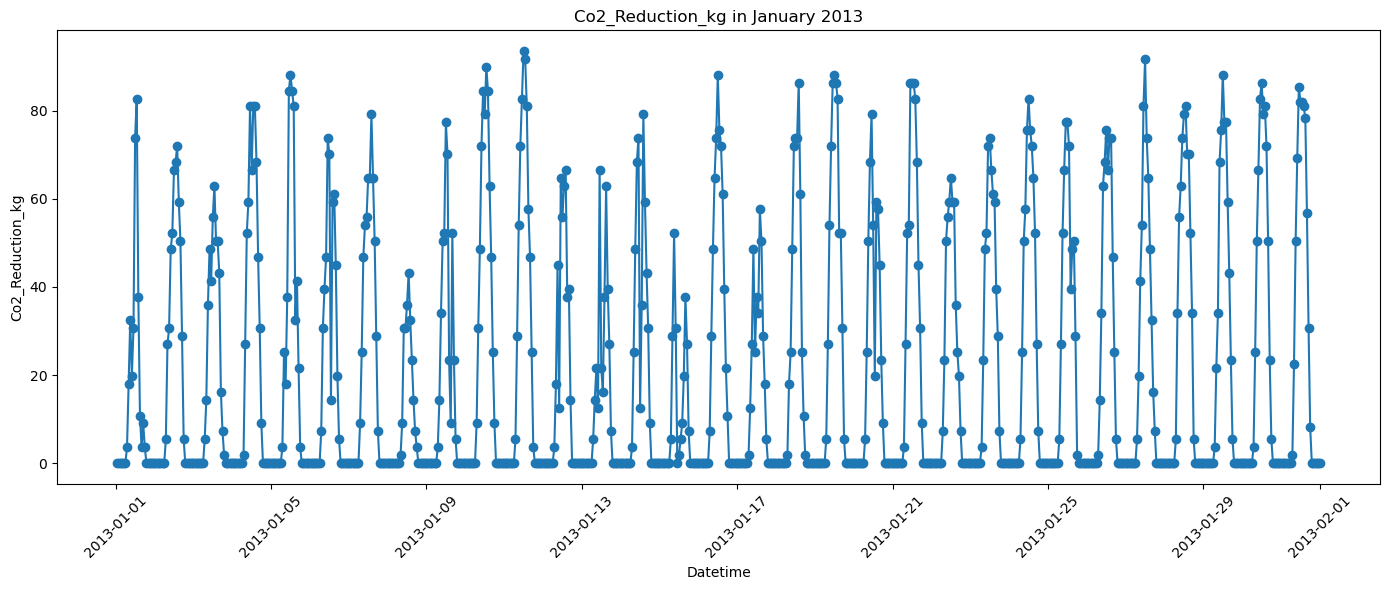

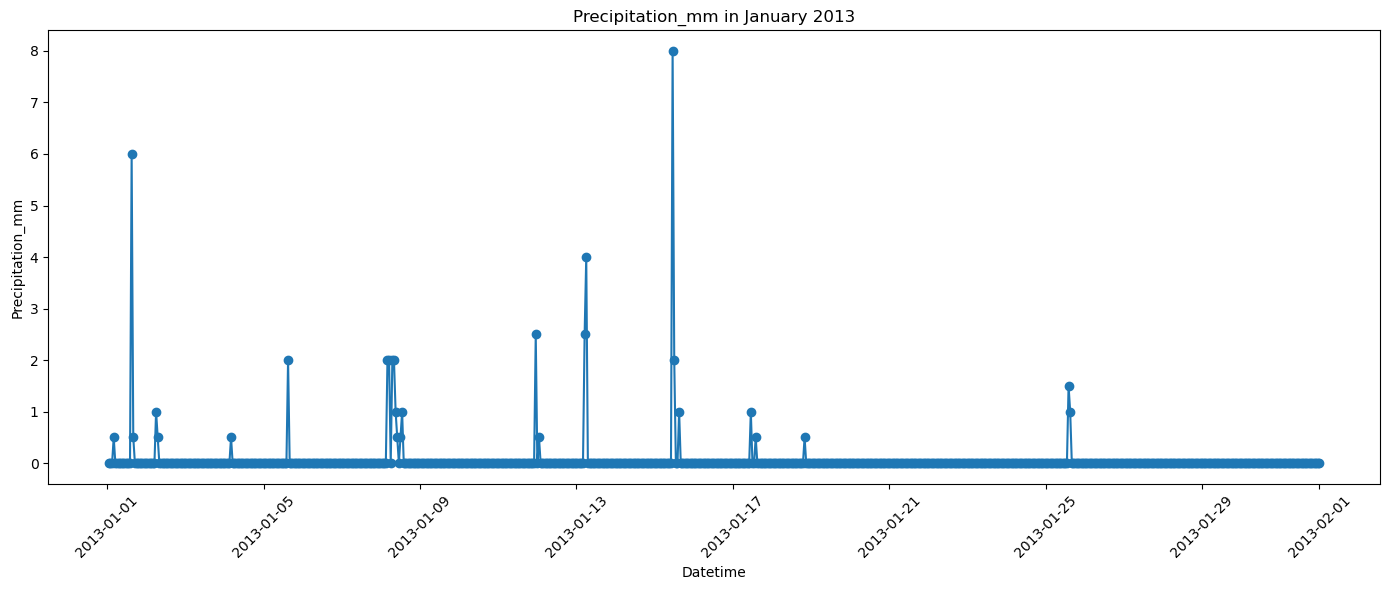

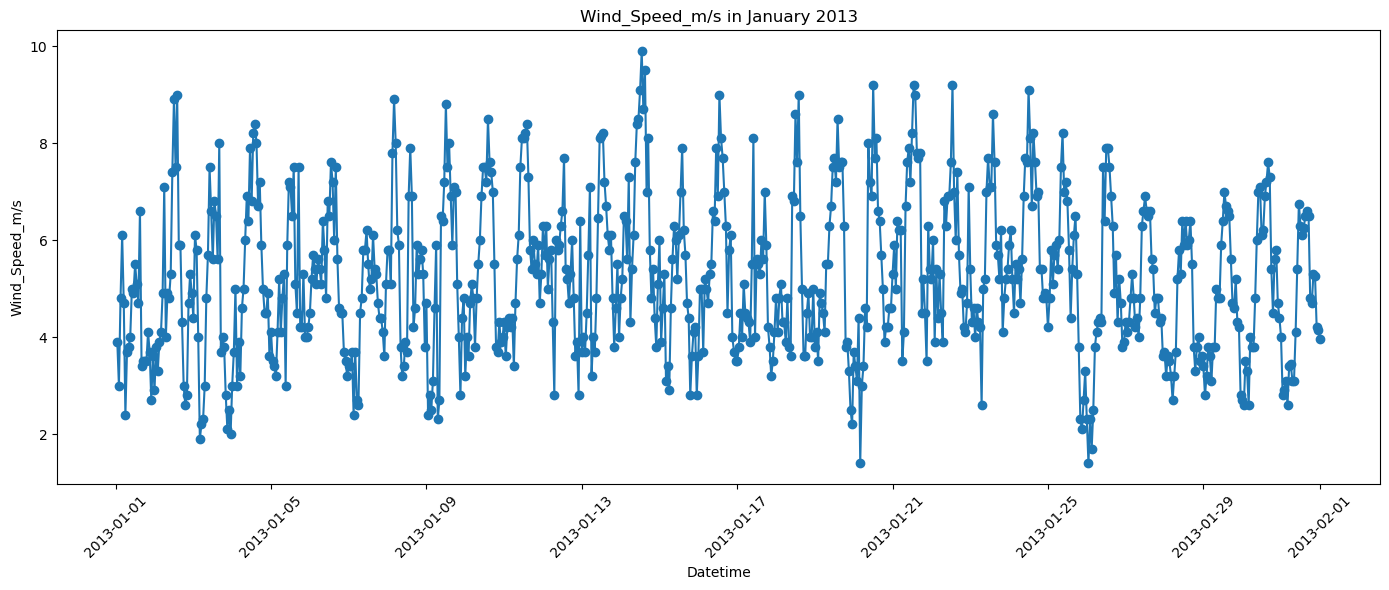

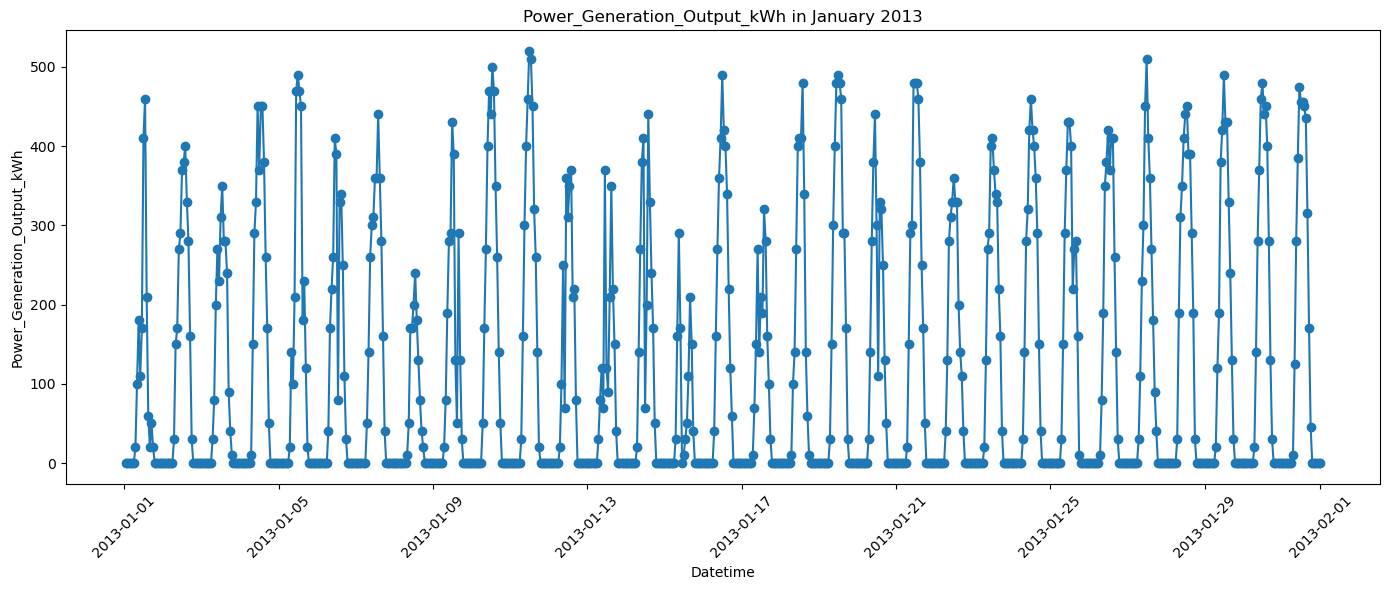

In [16]:
# Plotting for the Entire Month of January 2013 
for col in plot_features:
    plt.figure(figsize=(14, 6))
    plt.plot(january_df['combined_dt'], january_df[col], marker='o', linestyle='-')
    plt.title(f"{col} in January 2013")
    plt.xlabel("Datetime")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Feature Selection Methods

Pearson Correlation

Pearson Correlations with target:
Power_Generation_Output_kWh                  1.000000
Co2_Reduction_kg                             1.000000
Tilt_solar_incident_radiation_w/m2           0.987990
Global_horizontal_irradiance_GHI_W/m2        0.987150
Mean_Module_Temperature_deg_oC               0.949631
Mean_Open_Air_Temperature_deg_oC             0.828087
Diffuse_Horizontal_incident_radiation_DHI    0.816170
Wind_Speed_m/s                               0.438189
Precipitation_mm                             0.063792
Name: Power_Generation_Output_kWh, dtype: float64


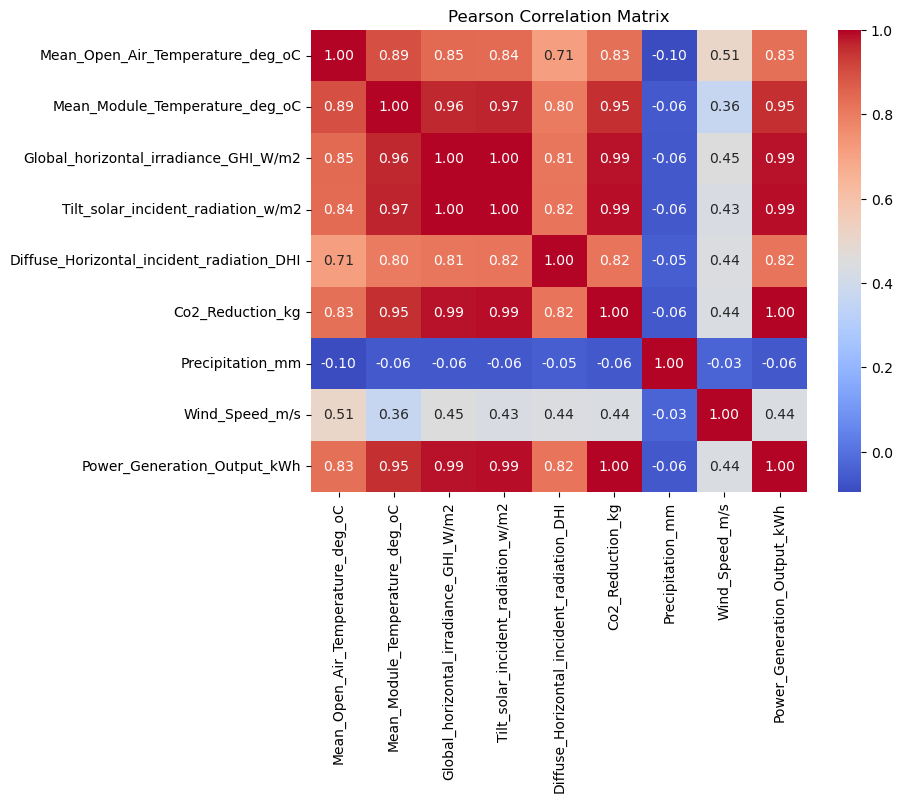

In [17]:
# Create a subset DataFrame with the features and target
df_subset = df[features + [target]]

# Calculate Pearson correlation matrix
pearson_corr = df_subset.corr()

# Display correlation values with the target, sorted by absolute correlation
pearson_target_corr = pearson_corr[target].abs().sort_values(ascending=False)
print("Pearson Correlations with target:")
print(pearson_target_corr)

# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

Spearman correlation

Spearman Correlations with target:
Power_Generation_Output_kWh                  1.000000
Co2_Reduction_kg                             1.000000
Global_horizontal_irradiance_GHI_W/m2        0.984346
Tilt_solar_incident_radiation_w/m2           0.981425
Diffuse_Horizontal_incident_radiation_DHI    0.939254
Mean_Module_Temperature_deg_oC               0.883625
Mean_Open_Air_Temperature_deg_oC             0.773777
Wind_Speed_m/s                               0.397319
Precipitation_mm                             0.076523
Name: Power_Generation_Output_kWh, dtype: float64


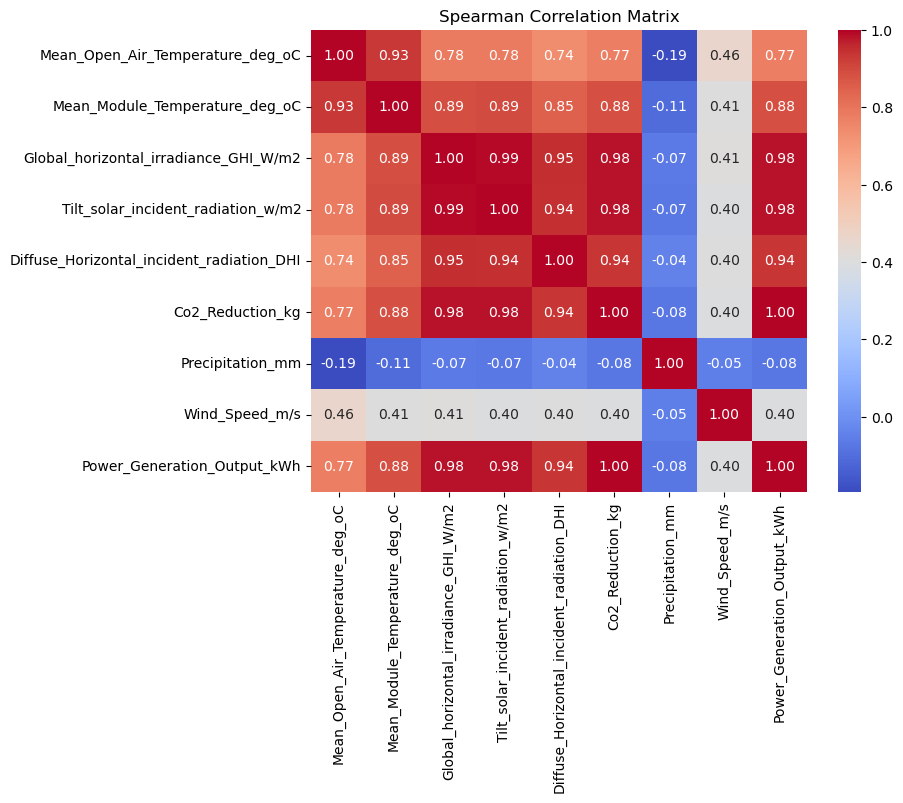

In [18]:
# Calculate Spearman correlation matrix
spearman_corr = df_subset.corr(method="spearman")

# Display correlation values with the target, sorted by absolute correlation
spearman_target_corr = spearman_corr[target].abs().sort_values(ascending=False)
print("Spearman Correlations with target:")
print(spearman_target_corr)

# Visualize the Spearman correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

Mutual Information

In [19]:
# Prepare the feature matrix X and target vector y
X = df_subset[features]
y = df_subset[target]

# Calculate mutual information between each feature and the target
mi = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi, index=features).sort_values(ascending=False)

print("Mutual Information between features and target:")
print(mi_series)

Mutual Information between features and target:
Co2_Reduction_kg                             2.633907
Global_horizontal_irradiance_GHI_W/m2        1.757219
Tilt_solar_incident_radiation_w/m2           1.745598
Diffuse_Horizontal_incident_radiation_DHI    1.068008
Mean_Module_Temperature_deg_oC               1.029242
Mean_Open_Air_Temperature_deg_oC             0.606509
Wind_Speed_m/s                               0.210356
Precipitation_mm                             0.016798
dtype: float64


Selected Features

In [20]:
# Keeping ALL Hours
print("Keeping ALL hours (full 24-hour training).")
if "Time_hrs" in df.columns:
    print("Hour column distribution:")
    print(df["Time_hrs"].value_counts())


# Select Features and Target
print("Selecting the most correlated features and the target variable.")
features = [
    "Global_horizontal_irradiance_GHI_W/m2",
    "Tilt_solar_incident_radiation_w/m2",
    "Diffuse_Horizontal_incident_radiation_DHI",
    "Co2_Reduction_kg",
    "Mean_Open_Air_Temperature_deg_oC"
]
target = "Power_Generation_Output_kWh"

# Extract input features and target values from the DataFrame.
input_features = df[features].values
output_feature = df[target].values.reshape(-1, 1)
print("Input features shape:", input_features.shape)
print("Target feature shape:", output_feature.shape)

Keeping ALL hours (full 24-hour training).
Hour column distribution:
01:00    365
02:00    365
23:00    365
22:00    365
21:00    365
20:00    365
19:00    365
18:00    365
17:00    365
16:00    365
15:00    365
14:00    365
13:00    365
12:00    365
11:00    365
10:00    365
09:00    365
08:00    365
07:00    365
06:00    365
05:00    365
04:00    365
03:00    365
24:00    365
Name: Time_hrs, dtype: int64
Selecting the most correlated features and the target variable.
Input features shape: (8760, 5)
Target feature shape: (8760, 1)


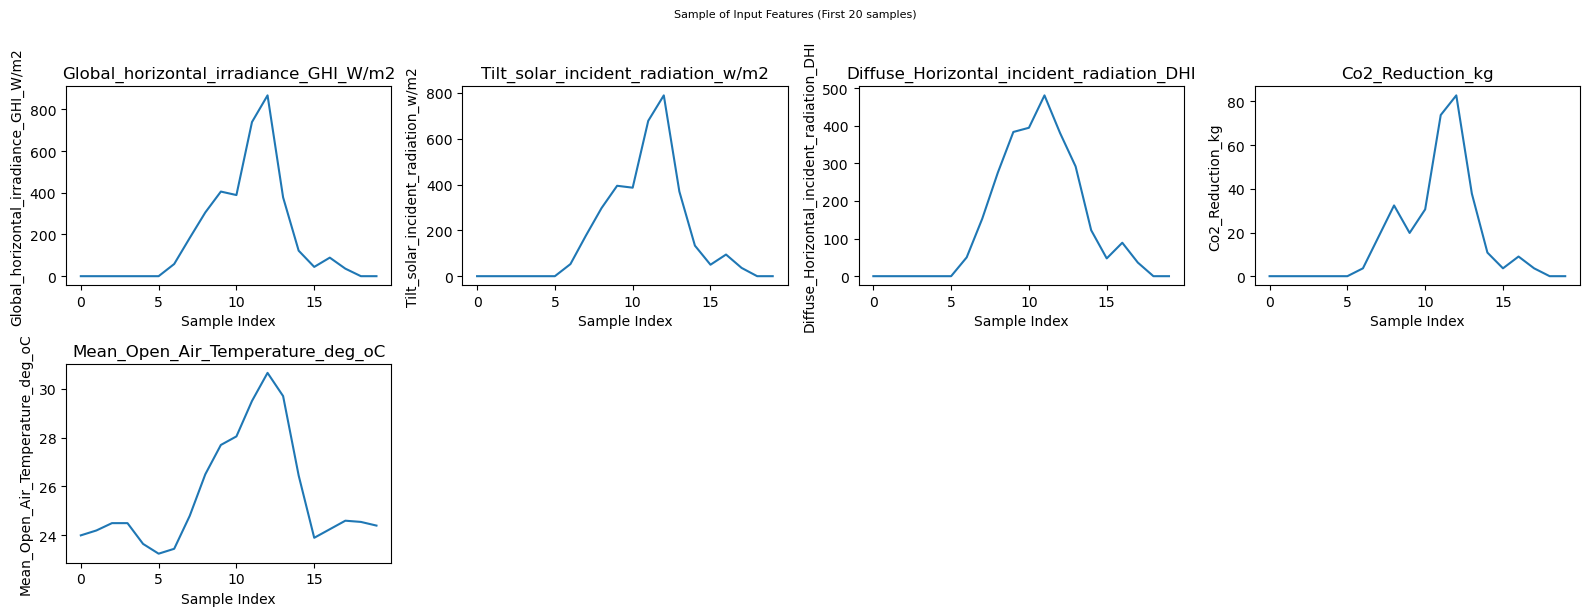

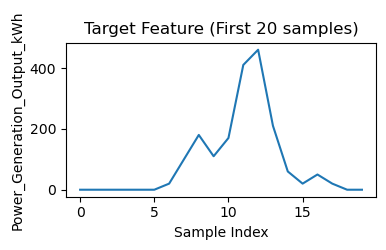

In [21]:
# Visualize the first 20 samples of each input feature in a 3x2 grid.
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()  

for i, feat in enumerate(features):
    axes[i].plot(input_features[:20, i])
    axes[i].set_title(feat)
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel(feat)


if len(features) < len(axes):
    for j in range(len(features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Sample of Input Features (First 20 samples)", fontsize=8, y=1.02)
plt.show()

# Visualize the target variable.
plt.figure(figsize=(4, 2))
plt.plot(output_feature[:20])
plt.title("Target Feature (First 20 samples)")
plt.xlabel("Sample Index")
plt.ylabel(target)
plt.show()


Outlier Removal

Removing outliers using Isolation Forest on combined inputs and target.
Combined data shape before outlier removal: (8760, 6)
Data shape after outlier removal: (8584, 5) (8584, 1)


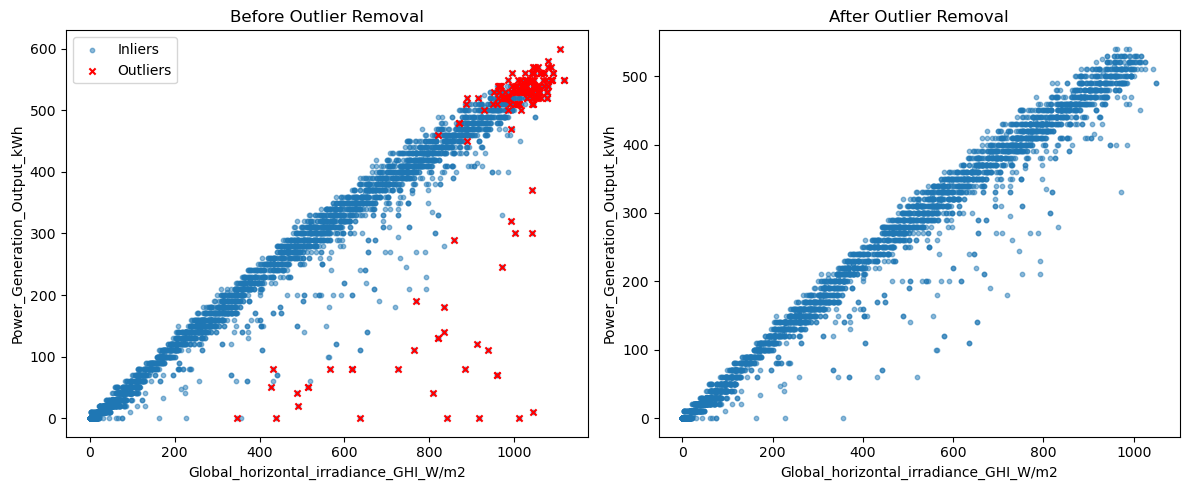

In [22]:
# Remove Outliers using Isolation Forest
print("Removing outliers using Isolation Forest on combined inputs and target.")

# Combine inputs and target into one array.
combined_data = np.hstack((input_features, output_feature))
print("Combined data shape before outlier removal:", combined_data.shape)

# Instantiate IsolationForest with 2% expected contamination.
iso_forest = IsolationForest(contamination=0.02, random_state=42)
# Fit the model and predict outliers (-1 are outliers, 1 are inliers).
outliers = iso_forest.fit_predict(combined_data)
mask = outliers == 1  # Keep only inliers (rows with label 1)

# Filter out the outliers from both inputs and target.
input_features = input_features[mask]
output_feature = output_feature[mask]
print("Data shape after outlier removal:", input_features.shape, output_feature.shape)

# Visualize the effect of outlier removal on the first feature vs. target.
plt.figure(figsize=(12, 5))

# Plot Before Outlier Removal (with outliers highlighted)
plt.subplot(1, 2, 1)
plt.scatter(combined_data[:, 0], combined_data[:, -1], s=10, alpha=0.5, label='Inliers')
# Identify outlier indices (where outliers == -1)
outlier_indices = np.where(outliers == -1)[0]
plt.scatter(combined_data[outlier_indices, 0], combined_data[outlier_indices, -1],
            s=20, color='r', marker='x', label='Outliers')
plt.title("Before Outlier Removal")
plt.xlabel(features[0])
plt.ylabel(target)
plt.legend()

# Plot After Outlier Removal
plt.subplot(1, 2, 2)
plt.scatter(input_features[:, 0], output_feature, s=10, alpha=0.5)
plt.title("After Outlier Removal")
plt.xlabel(features[0])
plt.ylabel(target)
plt.tight_layout()
plt.show()

Feature Engineering

Selection of Appropriate Feature for Feature Engineering

Feature: Global_horizontal_irradiance_GHI_W/m2
Top 3 lags (lag, ACF): [(1, 0.9106598842849747), (24, 0.8997606883652293), (48, 0.8831890499425537)]


<Figure size 800x400 with 0 Axes>

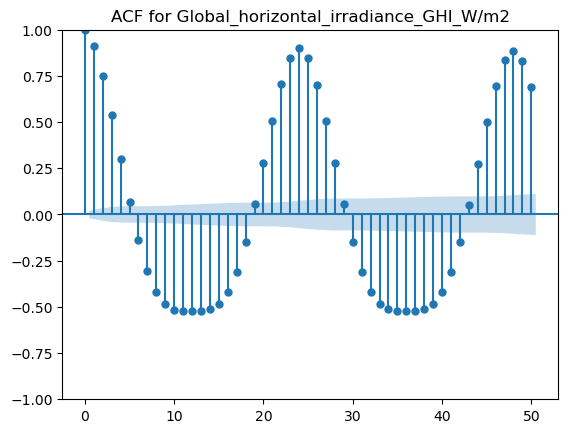

Feature: Tilt_solar_incident_radiation_w/m2
Top 3 lags (lag, ACF): [(1, 0.9118473016563211), (24, 0.9025030603474377), (48, 0.8856647625509174)]


<Figure size 800x400 with 0 Axes>

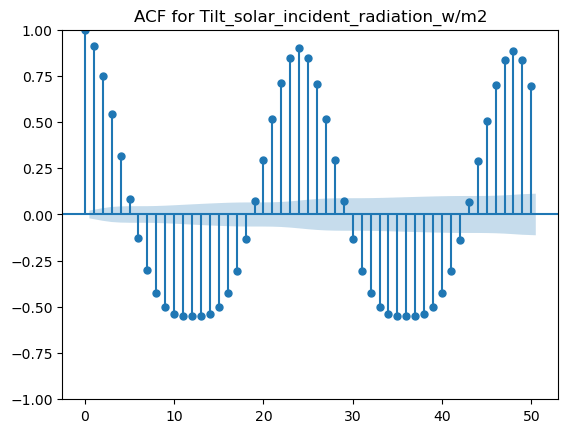

Feature: Diffuse_Horizontal_incident_radiation_DHI
Top 3 lags (lag, ACF): [(1, 0.902701423863455), (24, 0.8583370593247344), (48, 0.8243175480450391)]


<Figure size 800x400 with 0 Axes>

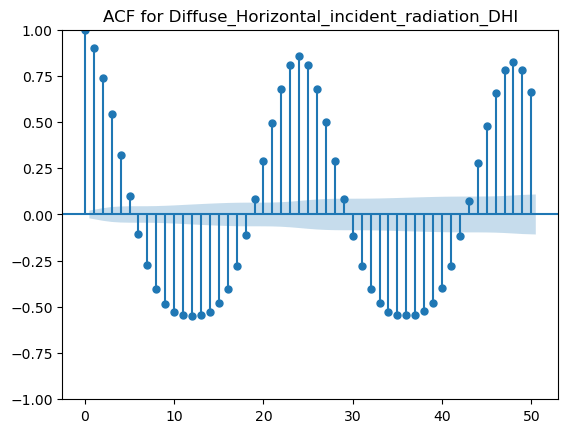

Feature: Co2_Reduction_kg
Top 3 lags (lag, ACF): [(1, 0.9021608719963062), (24, 0.8894971227483177), (48, 0.8738670051367105)]


<Figure size 800x400 with 0 Axes>

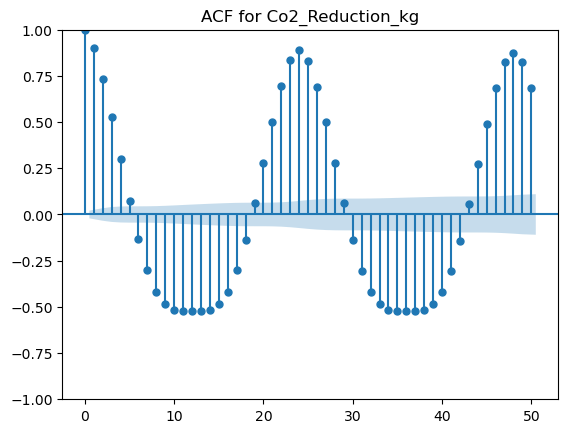

Feature: Mean_Open_Air_Temperature_deg_oC
Top 3 lags (lag, ACF): [(1, 0.9494447226924412), (24, 0.8808373866826475), (48, 0.8499108415434526)]


<Figure size 800x400 with 0 Axes>

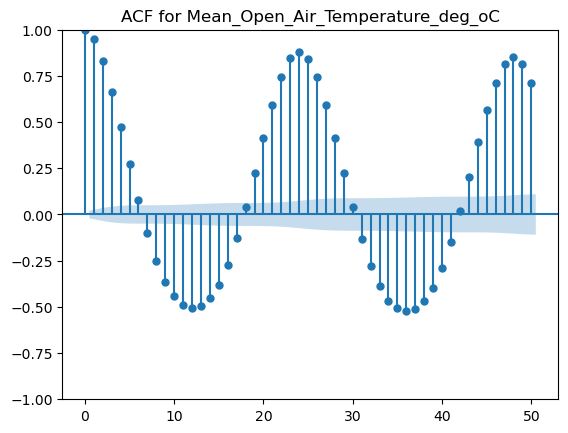


Selected best lag features for each climate variable:
Global_horizontal_irradiance_GHI_W/m2: [(1, 0.9106598842849747), (24, 0.8997606883652293), (48, 0.8831890499425537)]
Tilt_solar_incident_radiation_w/m2: [(1, 0.9118473016563211), (24, 0.9025030603474377), (48, 0.8856647625509174)]
Diffuse_Horizontal_incident_radiation_DHI: [(1, 0.902701423863455), (24, 0.8583370593247344), (48, 0.8243175480450391)]
Co2_Reduction_kg: [(1, 0.9021608719963062), (24, 0.8894971227483177), (48, 0.8738670051367105)]
Mean_Open_Air_Temperature_deg_oC: [(1, 0.9494447226924412), (24, 0.8808373866826475), (48, 0.8499108415434526)]


In [23]:
# Define the number of lags you want to compute
nlags = 50

# Dictionary to store best lag features for each climate feature
lag_features = {}

# Loop through each feature, compute its autocorrelation, and select top lags
for feature in features:
    series = df[feature]
    
    # Compute autocorrelation values up to nlags lags
    acf_vals = acf(series, nlags=nlags, fft=True)
    lags = np.arange(0, nlags+1)
    
    # Combine lags and acf values into pairs
    lag_acf_pairs = list(zip(lags[1:], acf_vals[1:]))
    
    # Sort by absolute autocorrelation value in descending order
    lag_acf_pairs_sorted = sorted(lag_acf_pairs, key=lambda x: abs(x[1]), reverse=True)
    
    # Select the top 3 lags 
    best_lags = lag_acf_pairs_sorted[:3]
    lag_features[feature] = best_lags
    
    print(f"Feature: {feature}")
    print("Top 3 lags (lag, ACF):", best_lags)
    
    # Plot the ACF for visualization
    plt.figure(figsize=(8, 4))
    plot_acf(series, lags=nlags, title=f"ACF for {feature}")
    plt.show()

print("\nSelected best lag features for each climate variable:")
for feat, lags in lag_features.items():
    print(f"{feat}: {lags}")

Lag Features Creation

Creating lag features for previous hour and previous day.
First 10 rows after adding lag features:
   Global_horizontal_irradiance_GHI_W/m2  Tilt_solar_incident_radiation_w/m2  \
0                               0.000000                            0.000000   
1                               0.000000                            0.000000   
2                               0.000000                            0.000000   
3                               0.000000                            0.000000   
4                               0.000000                            0.000000   
5                               0.000000                            0.000000   
6                              58.333333                           52.777778   
7                             183.333333                          177.777778   
8                             305.555556                          297.222222   
9                             405.555556                          394.444444   

   Diffuse_Horizonta

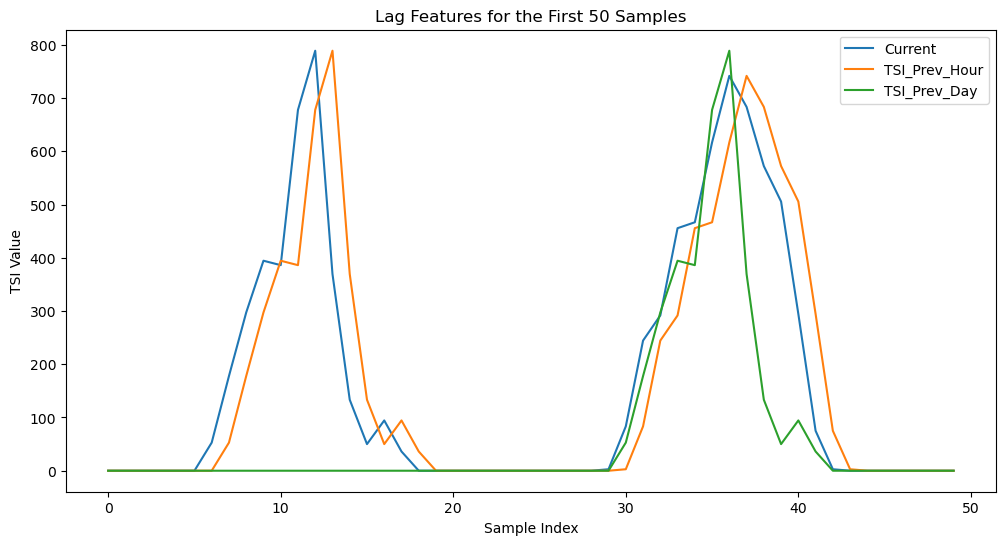

In [24]:
# Create Lag Features (Prev Hour & Prev Day)

print("Creating lag features for previous hour and previous day.")

# Create a DataFrame from the scaled inputs with column names.
df_lagged = pd.DataFrame(input_features, columns=features)
# Create a lagged feature representing the previous hour's value.
df_lagged["TSI_Prev_Hour"] = df_lagged["Tilt_solar_incident_radiation_w/m2"].shift(1).fillna(0)
# Create a lagged feature representing the value from 24 hours earlier.
df_lagged["TSI_Prev_Day"] = df_lagged["Tilt_solar_incident_radiation_w/m2"].shift(24).fillna(0)
print("First 10 rows after adding lag features:")
print(df_lagged.head(10))

# Visualize the current feature along with its lagged versions (first 50 samples).
plt.figure(figsize=(12, 6))
plt.plot(df_lagged["Tilt_solar_incident_radiation_w/m2"][:50], label="Current")
plt.plot(df_lagged["TSI_Prev_Hour"][:50], label="TSI_Prev_Hour")
plt.plot(df_lagged["TSI_Prev_Day"][:50], label="TSI_Prev_Day")
plt.title("Lag Features for the First 50 Samples")
plt.xlabel("Sample Index")
plt.ylabel("TSI Value")
plt.legend()
plt.show()

# Convert the DataFrame back to a NumPy array.
input_features = df_lagged.values

Data Normalization

Normalizing data using MinMaxScaler.
Scaled inputs shape: (8584, 7)
Scaled output shape: (8584, 1)


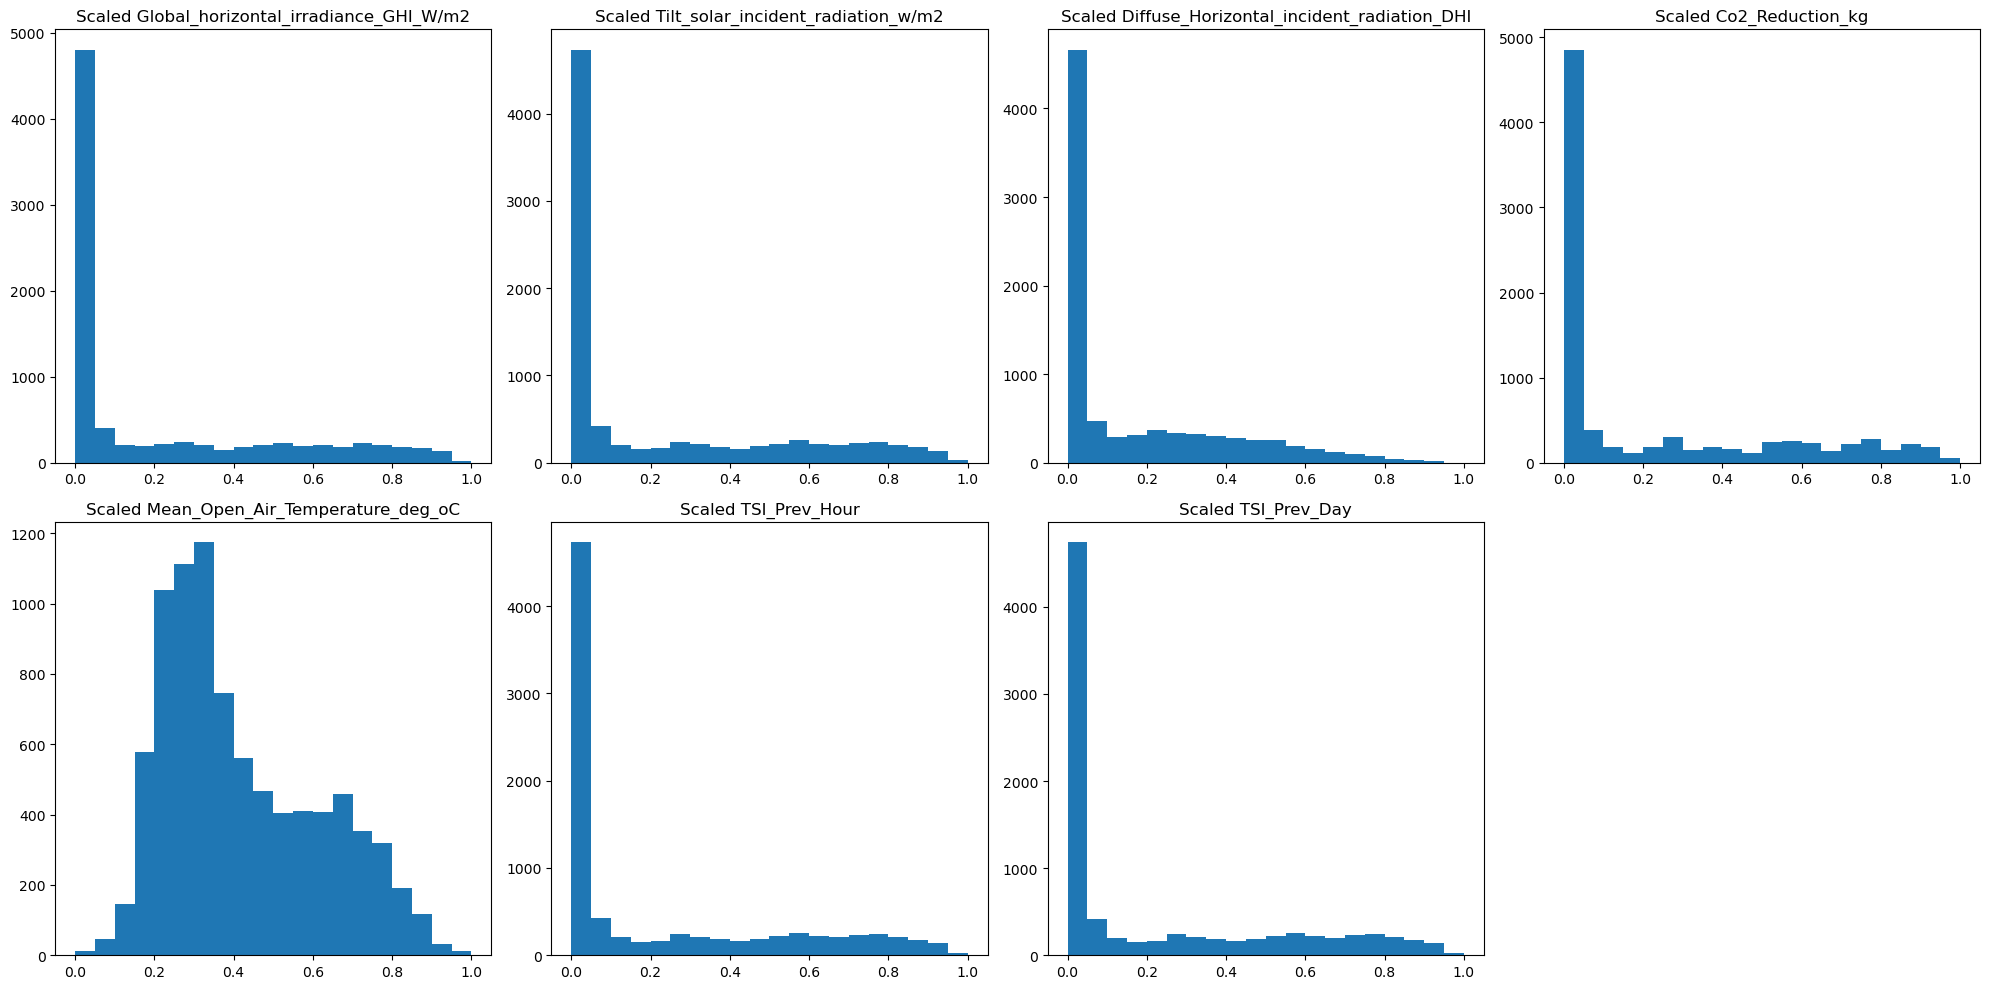

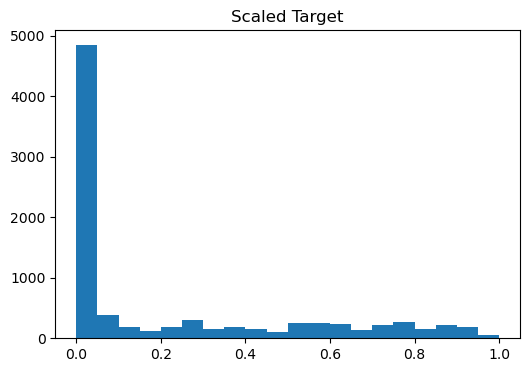

In [25]:
# Normalize Data
print("Normalizing data using MinMaxScaler.")

# Initialize scalers for inputs and target.
scaler_inputs = MinMaxScaler()
scaler_output = MinMaxScaler()

# Scale (normalize) input features and target to the range [0, 1].
scaled_inputs = scaler_inputs.fit_transform(input_features)
scaled_output = scaler_output.fit_transform(output_feature)
print("Scaled inputs shape:", scaled_inputs.shape)
print("Scaled output shape:", scaled_output.shape)

feature_names = [
    "Global_horizontal_irradiance_GHI_W/m2",
    "Tilt_solar_incident_radiation_w/m2",
    "Diffuse_Horizontal_incident_radiation_DHI",
    "Co2_Reduction_kg",
    "Mean_Open_Air_Temperature_deg_oC",
    "TSI_Prev_Hour",  
    "TSI_Prev_Day"   
]

# Plot histograms of scaled input features using the defined feature names.
num_features = scaled_inputs.shape[1]  
nrows = 2
ncols = math.ceil(num_features / nrows)  

plt.figure(figsize=(ncols * 5, nrows * 5))
for i in range(num_features):
    plt.subplot(nrows, ncols, i + 1)
    plt.hist(scaled_inputs[:, i], bins=20)
    plt.title(f"Scaled {feature_names[i]}")
plt.tight_layout()
plt.show()

# Plot histogram for scaled target.
plt.figure(figsize=(6, 4))
plt.hist(scaled_output, bins=20)
plt.title("Scaled Target")
plt.show()


Data Denoising

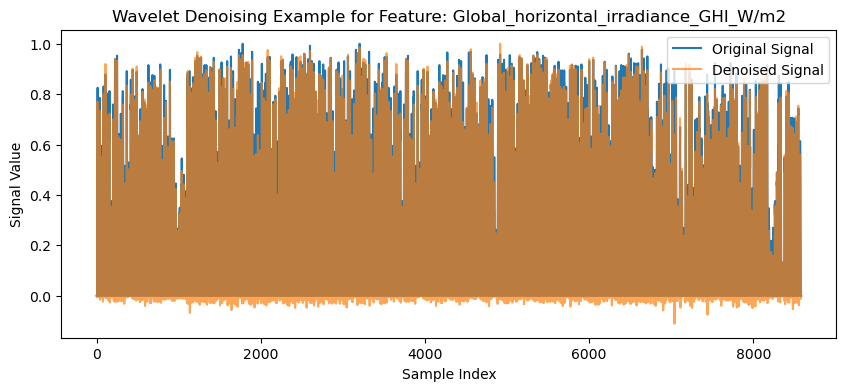

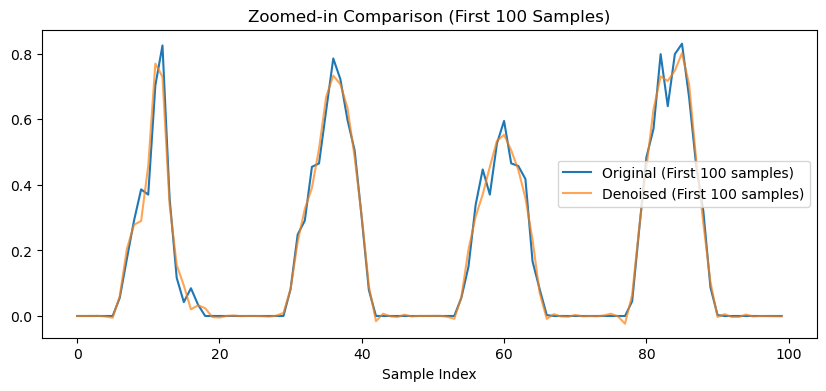

In [26]:
# Using denoising function
def wavelet_denoising(signal):
    """
    Applies wavelet denoising on a 1D signal using Daubechies 4 wavelet.
    - Decomposes the signal to level 1.
    - Zeroes out detail coefficients (noise).
    - Reconstructs the signal using the approximation coefficients.
    """
    coeffs = pywt.wavedec(signal, 'db4', level=1)  # Decompose signal
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]  # Remove detail coefficients
    return pywt.waverec(coeffs, 'db4')[:len(signal)]  # Reconstruct and match length


example_signal = scaled_inputs[:, 0]
denoised_signal = wavelet_denoising(example_signal)

# Plot the full signal for visual inspection
plt.figure(figsize=(10, 4))
plt.plot(example_signal, label="Original Signal")
plt.plot(denoised_signal, label="Denoised Signal", alpha=0.7)
plt.title("Wavelet Denoising Example for Feature: " + features[0])
plt.xlabel("Sample Index")
plt.ylabel("Signal Value")
plt.legend()
plt.show()

# Zoom in on the first 100 samples for finer detail comparison
plt.figure(figsize=(10, 4))
plt.plot(example_signal[:100], label="Original (First 100 samples)")
plt.plot(denoised_signal[:100], label="Denoised (First 100 samples)", alpha=0.7)
plt.title("Zoomed-in Comparison (First 100 Samples)")
plt.xlabel("Sample Index")
plt.legend()
plt.show()


Evaluation of Denoising

Frequency domain analysis using FFT

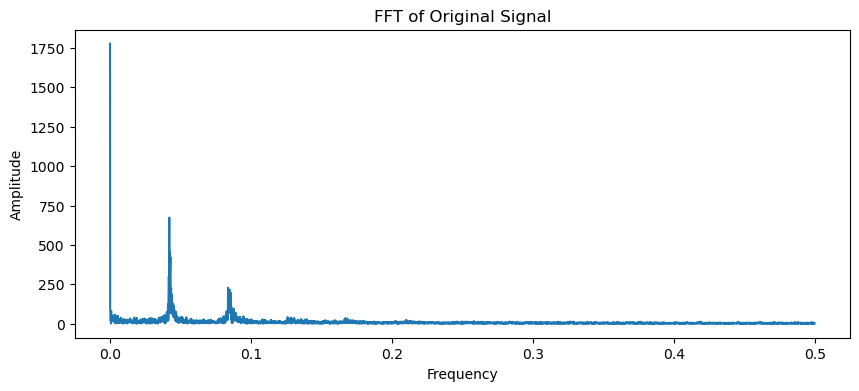

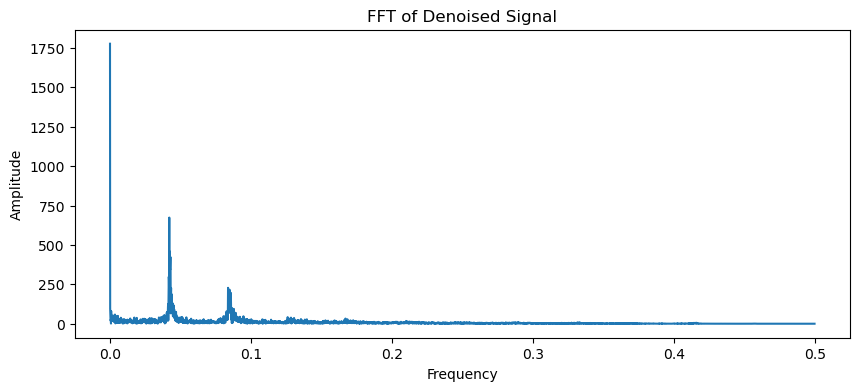

In [27]:
def plot_fft(signal, title, sample_rate=1.0):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sample_rate)
    plt.figure(figsize=(10, 4))
    plt.plot(xf[:N//2], np.abs(yf[:N//2]))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.show()

plot_fft(example_signal, "FFT of Original Signal")
plot_fft(denoised_signal, "FFT of Denoised Signal")


Autocorrelation Analysis

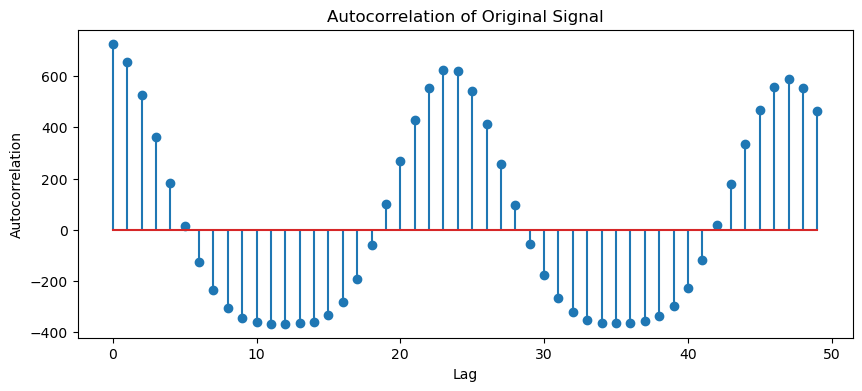

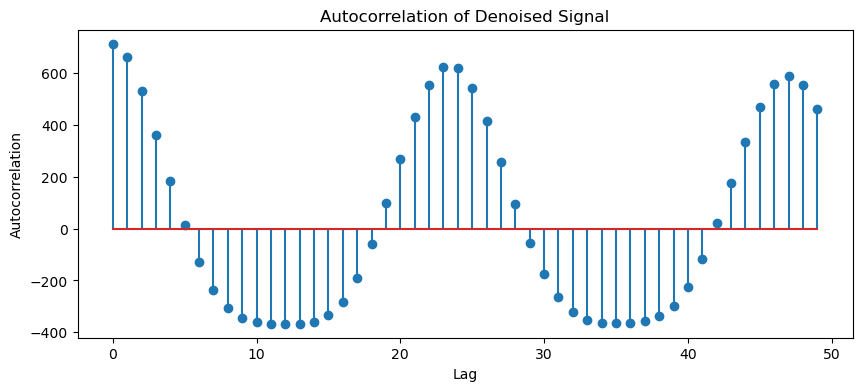

In [28]:
def plot_autocorrelation(signal, title, max_lag=50):
    signal_centered = signal - np.mean(signal)
    autocorr = np.correlate(signal_centered, signal_centered, mode='full')
    mid = len(autocorr) // 2
    lags = np.arange(0, max_lag)
    plt.figure(figsize=(10, 4))
    plt.stem(lags, autocorr[mid:mid+max_lag], use_line_collection=True)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

plot_autocorrelation(example_signal, "Autocorrelation of Original Signal")
plot_autocorrelation(denoised_signal, "Autocorrelation of Denoised Signal")


Variance-based Evaluation

In [29]:
var_original = np.var(example_signal)
var_denoised = np.var(denoised_signal)
removed_noise = example_signal - denoised_signal
var_noise = np.var(removed_noise)

print("Variance of Original Signal:", var_original)
print("Variance of Denoised Signal:", var_denoised)
print("Variance of Removed Noise:", var_noise)


Variance of Original Signal: 0.08468240369828019
Variance of Denoised Signal: 0.08319460266224814
Variance of Removed Noise: 0.0014878010360320501


In [30]:
# Apply denoising to all input features.
for i in range(input_features.shape[1]):
    scaled_inputs[:, i] = wavelet_denoising(scaled_inputs[:, i])

# Apply denoising to the target, then clip its values to remain within [0, 1].
denoised_output = wavelet_denoising(scaled_output.flatten())
scaled_output = np.clip(denoised_output, 0, 1).reshape(-1, 1)

Dataset Stacking and Structuring 

In [31]:
# Stack Processed Features and Output

print("Stacking processed features and target output together.")

# Combine the processed input features and the target into one array.
tensor_data_normalized = np.column_stack((scaled_inputs, scaled_output))
print("Final stacked data shape:", tensor_data_normalized.shape)
print("First 5 rows of the final stacked data:")
print(tensor_data_normalized[:5])

Stacking processed features and target output together.
Final stacked data shape: (8584, 8)
First 5 rows of the final stacked data:
[[-5.41526381e-06 -3.49863348e-05  9.05195679e-06 -1.71537590e-04
   2.16858745e-01 -1.31780451e-04  0.00000000e+00  0.00000000e+00]
 [-1.68031926e-05 -1.08560200e-04  2.80876017e-05 -5.32269389e-04
   2.43298813e-01 -4.08905711e-04  0.00000000e+00  0.00000000e+00]
 [ 9.34790282e-05  1.88130753e-04  1.47615967e-04  1.27799507e-03
   2.48001139e-01  6.57876606e-04  0.00000000e+00  1.27799507e-03]
 [ 3.36731702e-04  8.85294519e-04  3.80025885e-04  5.44396687e-03
   2.39610605e-01  3.17712582e-03  0.00000000e+00  5.44396687e-03]
 [-1.45713340e-03 -1.45364095e-03 -1.28118315e-03 -3.26978333e-03
   2.12898677e-01 -1.03372092e-03  0.00000000e+00  0.00000000e+00]]


In [32]:
# Dataset Split (80% train, 10% validation, 10% test)

num_samples = len(tensor_data_normalized)
num_train = int(0.8 * num_samples)
num_valid = int(0.1 * num_samples)
num_test = num_samples - num_train - num_valid

print("Total samples:", num_samples)
print("Training samples:", num_train)
print("Validation samples:", num_valid)
print("Test samples:", num_test)

train_data = tensor_data_normalized[:num_train].T
val_data = tensor_data_normalized[num_train : num_train + num_valid].T
test_data = tensor_data_normalized[num_train + num_valid :].T

print("\nAfter transpose:")
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)


# Define sequence length
memdepth = 5

# Create Sequences

def create_sequences(data_array, memdepth):
    """
    data_array shape: (num_features + 1, T)
      - last row of data_array is the target 
    """
    sequences = []
    for i in range(data_array.shape[1] - memdepth):
        X = data_array[:-1, i : i + memdepth]  # all but last row -> features
        y = data_array[-1, i + memdepth]       # last row -> target
        sequences.append((X, y))
    return sequences

train_sequences = create_sequences(train_data, memdepth)
val_sequences = create_sequences(val_data, memdepth)
test_sequences = create_sequences(test_data, memdepth)


print("\nNumber of sequences:")
print("Training sequences:", len(train_sequences))
print("Validation sequences:", len(val_sequences))
print("Test sequences:", len(test_sequences))

if train_sequences:
    example_X, example_y = train_sequences[0]
    print("\nExample from first training sequence:")
    print("X shape (features, memdepth):", example_X.shape)
    print("y value:", example_y)

# Convert to PyTorch tensors
train_X = torch.Tensor([seq[0] for seq in train_sequences])  
train_y = torch.Tensor([seq[1] for seq in train_sequences]).view(-1, 1)
val_X = torch.Tensor([seq[0] for seq in val_sequences])
val_y = torch.Tensor([seq[1] for seq in val_sequences]).view(-1, 1)
test_X = torch.Tensor([seq[0] for seq in test_sequences])
test_y = torch.Tensor([seq[1] for seq in test_sequences]).view(-1, 1)

print("\nAfter converting to PyTorch tensors:")
print("train_X shape:", train_X.shape)
print("train_y shape:", train_y.shape)
print("val_X shape:", val_X.shape)
print("val_y shape:", val_y.shape)
print("test_X shape:", test_X.shape)
print("test_y shape:", test_y.shape)

Total samples: 8584
Training samples: 6867
Validation samples: 858
Test samples: 859

After transpose:
Train data shape: (8, 6867)
Validation data shape: (8, 858)
Test data shape: (8, 859)

Number of sequences:
Training sequences: 6862
Validation sequences: 853
Test sequences: 854

Example from first training sequence:
X shape (features, memdepth): (7, 5)
y value: 0.0

After converting to PyTorch tensors:
train_X shape: torch.Size([6862, 7, 5])
train_y shape: torch.Size([6862, 1])
val_X shape: torch.Size([853, 7, 5])
val_y shape: torch.Size([853, 1])
test_X shape: torch.Size([854, 7, 5])
test_y shape: torch.Size([854, 1])


CNN Model Architecture

In [33]:
# CNN Model Architecture
class CNNRegressor(nn.Module):
    def __init__(self, num_features, memdepth):
        super(CNNRegressor, self).__init__()

        # -- 3 convolution layers --
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, padding=1, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=2, padding=1, stride=1)

        # MaxPooling & Activation
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.tanh = nn.Tanh()

        # Dynamically compute the final flattened dimension
        with torch.no_grad():
            dummy_in = torch.zeros(1, 1, num_features, memdepth)  # (batch=1, channels=1, H=num_features, W=memdepth)
            out = self.pool(self.tanh(self.conv1(dummy_in)))
            out = self.pool(self.tanh(self.conv2(out)))
            out = self.pool(self.tanh(self.conv3(out)))
            flatten_dim = out.view(1, -1).shape[1]

        # Fully connected layers
        self.fc1 = nn.Linear(flatten_dim, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        # x: (batch, 1, num_features, memdepth)
        x = self.tanh(self.conv1(x))
        x = self.pool(x)

        x = self.tanh(self.conv2(x))
        x = self.pool(x)

        x = self.tanh(self.conv3(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # MLP layers
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        x = F.softplus(x)
        return x

num_features = train_X.shape[1]  
network = CNNRegressor(num_features=num_features, memdepth=memdepth)
print(network)

# Create DataLoaders

batch_size = 32
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=batch_size, shuffle=False, drop_last=False)


CNNRegressor(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (tanh): Tanh()
  (fc1): Linear(in_features=35, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


Model Training

Epoch 0: Train Loss = 0.0948, Validation Loss = 0.0419
Epoch 1: Train Loss = 0.0148, Validation Loss = 0.0115
Epoch 2: Train Loss = 0.0072, Validation Loss = 0.0062
Epoch 3: Train Loss = 0.0057, Validation Loss = 0.0056
Epoch 4: Train Loss = 0.0051, Validation Loss = 0.0049
Epoch 5: Train Loss = 0.0045, Validation Loss = 0.0044
Epoch 6: Train Loss = 0.0042, Validation Loss = 0.0043
Epoch 7: Train Loss = 0.0039, Validation Loss = 0.0041
Epoch 8: Train Loss = 0.0037, Validation Loss = 0.0050
Epoch 9: Train Loss = 0.0036, Validation Loss = 0.0037
Epoch 10: Train Loss = 0.0040, Validation Loss = 0.0042
Epoch 11: Train Loss = 0.0033, Validation Loss = 0.0036
Epoch 12: Train Loss = 0.0034, Validation Loss = 0.0040
Epoch 13: Train Loss = 0.0032, Validation Loss = 0.0037
Epoch 14: Train Loss = 0.0031, Validation Loss = 0.0035
Epoch 15: Train Loss = 0.0030, Validation Loss = 0.0046
Epoch 16: Train Loss = 0.0031, Validation Loss = 0.0036
Epoch 17: Train Loss = 0.0028, Validation Loss = 0.0034
Ep

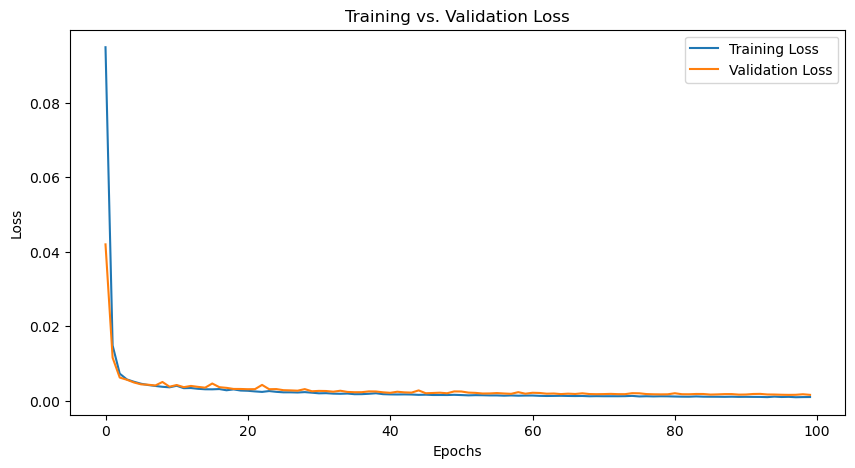

In [34]:
# Training Loop

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

max_epochs = 100
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses = [], []

for epoch in range(max_epochs):
    # Training
    network.train()
    epoch_train_loss = 0.0
    for inp, out in train_loader:
        inp = inp.unsqueeze(1)
        optimizer.zero_grad()
        pred = network(inp)
        loss = criterion(pred, out)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation
    network.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inp, out in val_loader:
            inp = inp.unsqueeze(1)
            pred = network(inp)
            epoch_val_loss += criterion(pred, out).item()

    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch}: Train Loss = {epoch_train_loss:.4f}, Validation Loss = {epoch_val_loss:.4f}")

    # Save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        torch.save(network.state_dict(), "Test_CNN_best_model.pth")
    else:
        patience_counter += 1

    # If patience_counter is 1000, break (arbitrary large patience to avoid early stops)
    if patience_counter >= 1000:
        print("Early stopping triggered.")
        break

# Plot the training vs. validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

Model Evaluation

In [35]:
# Evaluate the Best Model

network.load_state_dict(torch.load("Test_CNN_best_model.pth"))
network.eval()

with torch.no_grad():
    # Training predictions
    train_pred = network(train_X.unsqueeze(1)).numpy()
    train_true = train_y.numpy()

    # Test predictions
    test_pred = network(test_X.unsqueeze(1)).numpy()
    test_true = test_y.numpy()

# Inverse transform
train_pred_real = scaler_output.inverse_transform(train_pred)
train_true_real = scaler_output.inverse_transform(train_true)
test_pred_real = scaler_output.inverse_transform(test_pred)
test_true_real = scaler_output.inverse_transform(test_true)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(train_true_real, train_pred_real))
test_rmse  = np.sqrt(mean_squared_error(test_true_real,  test_pred_real))

train_r2   = r2_score(train_true_real, train_pred_real)
test_r2    = r2_score(test_true_real,  test_pred_real)

train_mae = mean_absolute_error(train_true_real, train_pred_real)
test_mae  = mean_absolute_error(test_true_real,  test_pred_real)

train_bias = np.mean(train_pred_real - train_true_real)
test_bias  = np.mean(test_pred_real - test_true_real)

print("---RMSE---")
print("Train RMSE (real scale):", train_rmse)
print("Test RMSE (real scale):", test_rmse)

print("---R²---")
print("Train R²:", train_r2)
print("Test R²:", test_r2)

print("---MAE---")
print("Train MAE (real scale):", train_mae)
print("Test MAE (real scale):", test_mae)

print("---Bias---")
print("Train Bias (real scale):", train_bias)
print("Test Bias (real scale):", test_bias)


---RMSE---
Train RMSE (real scale): 15.725453
Test RMSE (real scale): 16.494684
---R²---
Train R²: 0.9908355029845564
Test R²: 0.9880023989682988
---MAE---
Train MAE (real scale): 10.454826
Test MAE (real scale): 10.843464
---Bias---
Train Bias (real scale): 1.9008329
Test Bias (real scale): 2.1055667


In [36]:
# Count Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(network)
print("Total trainable parameters:", total_params)


Total trainable parameters: 1778


Actuals vs Forecast Results Plots

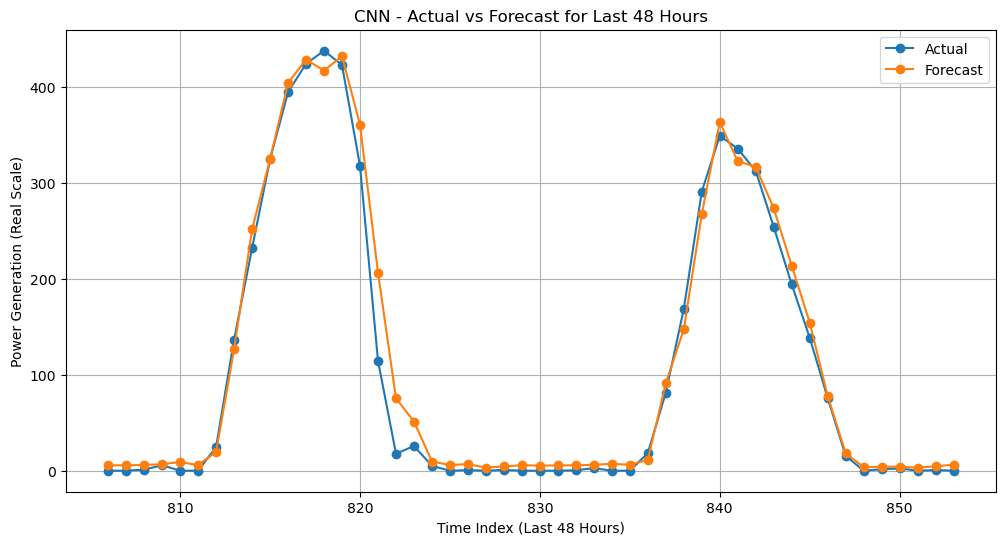

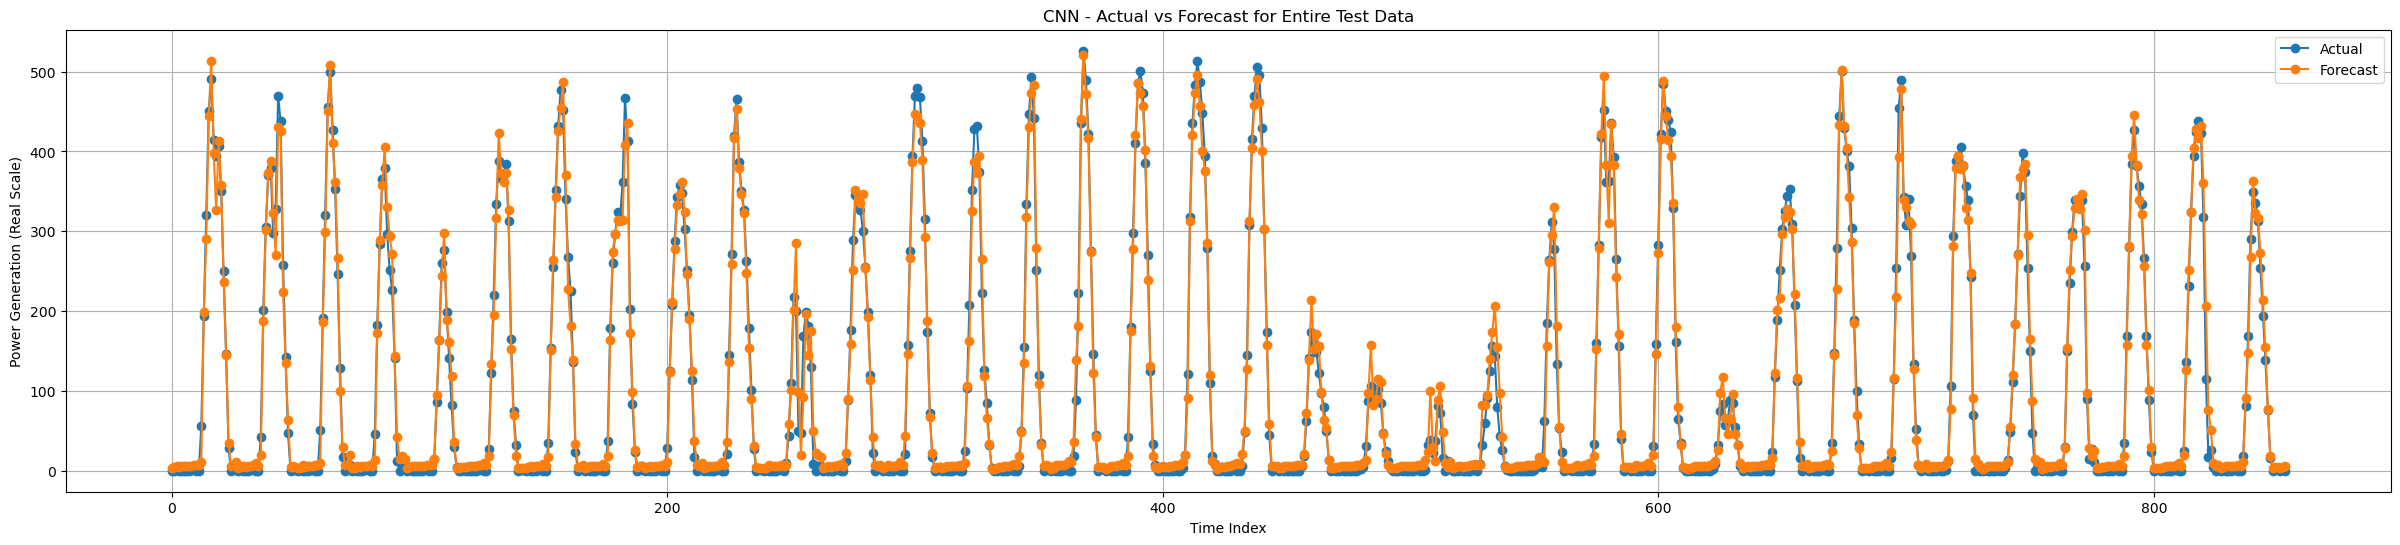

In [37]:
# as numpy arrays with shape (n, 1) from evaluation step.
# flatten them to get 1D arrays.
test_true = test_true_real.flatten()
test_pred = test_pred_real.flatten()


# Plot 1: Last 48 Hours
# Select the last 48 data points
last_48_indices = np.arange(len(test_true) - 48, len(test_true))

plt.figure(figsize=(12, 6))
plt.plot(last_48_indices, test_true[-48:], marker='o', label='Actual')
plt.plot(last_48_indices, test_pred[-48:], marker='o', label='Forecast')
plt.title('CNN - Actual vs Forecast for Last 48 Hours')
plt.xlabel('Time Index (Last 48 Hours)')
plt.ylabel('Power Generation (Real Scale)')
plt.legend()
plt.grid(True)
plt.show()


# Plot 2: Entire Test Data
plt.figure(figsize=(30, 6))
plt.plot(test_true, marker='o', label='Actual')
plt.plot(test_pred, marker='o', label='Forecast')
plt.title('CNN - Actual vs Forecast for Entire Test Data')
plt.xlabel('Time Index')
plt.ylabel('Power Generation (Real Scale)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
# saving predictions of the test set
preds_CNN_test = test_pred 
preds_true = test_true

# Save the predictions to a file
np.save('preds_CNN_.npy', preds_CNN_test)
np.save('preds_Test_True_.npy', preds_true)